En este proyecto de análisis de datos mediante aprendizaje automático se desarrolla un sistema de análisis de datos basado en IA y su aplicación en el Análisis de Supervivencia aplicado a ala retención de clienets de un centro deportivo.

por A Espín Rearte


# Importación y de datos y librerias

En esta sección se establece la conexión con el directorio que contiene los archivos de datos, se importan los paquetes necesarios para el análisis y se leen los datasets.

In [ ]:
!pip install -U scikit-learn==1.3.2
!pip install scikit-survival==0.22.1
!pip install lifelines

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 17.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 10.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=2024dc2ebcceb95186042b105fa619778fbe0d9757e2747a86b698b0e01761d6
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Importamos librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
%matplotlib inline

# importar todas las funciones de pylab
from pylab import *
# Ouliers y nulls
from sklearn.decomposition import PCA
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from statsmodels.imputation import mice
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import sksurv.ensemble
from sklearn.model_selection import train_test_split

from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

from sklearn.covariance import MinCovDet

from sklearn.ensemble import IsolationForest

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

from sksurv.linear_model import CoxPHSurvivalAnalysis

from sksurv.svm import HingeLossSurvivalSVM

from sksurv.svm import MinlipSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.functions import StepFunction

from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [ ]:
# Configuracion de opciones de impresion pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

# Carga de los archivos Excel
altes_i_baixes = '/content/drive/MyDrive/TFG/DATASHEETS/ALTES_I_BAIXES.xlsx'
clientes = '/content/drive/MyDrive/TFG/DATASHEETS/CLIENTS_COMPLET.xlsx'
consum_altres = '/content/drive/MyDrive/TFG/DATASHEETS/CONSUM_ALTRES.xlsx'
darrer_rebut = '/content/drive/MyDrive/TFG/DATASHEETS/data_darrer_rebuts.xlsx'
entradesclaret = '/content/drive/MyDrive/TFG/DATASHEETS/EntradesClaretNet.CSV'
reservas = '/content/drive/MyDrive/TFG/DATASHEETS/RESERVAS1.xlsx'
formaspago = '/content/drive/MyDrive/TFG/DATASHEETS/pagos.xlsx'

# Lectura de los archivos Excel en dataframes de Pandas
data_altes_i_baixes = pd.read_excel(altes_i_baixes)
data_clientes = pd.read_excel(clientes)
data_consum_altres = pd.read_excel(consum_altres)
data_darrer_rebut = pd.read_excel(darrer_rebut)
data_formaspago = pd.read_excel(formaspago)

import datetime as dt

fecha_referencia = dt.datetime(2024, 1, 12)


In [ ]:

# Leemos Reservas aparte por el gran tamaño
data_reservas = pd.read_excel(reservas)


In [ ]:
# Lista de enteros que representan la longitud de cada campo de entradesclaret para leer el archivo
# con ancho de columna fijo. Lee entradesclaret aparte por el tamaño
widths = [37, 24, 16, 24,14, 50]
data_entradesclaret = pd.read_fwf(entradesclaret, widths=widths)

# FASE 1 Preparación y EDA

## Caracteristicas de datasets

En esta sección se leen los datasets y vemos dimensiones y tipos de datos

In [ ]:
# Se imprimen los diferntes datasets para ver como estan estructurados.
print(data_altes_i_baixes)
print(data_altes_i_baixes.dtypes)

       Tipus                Data     Abonat  Operador  ModalitatCodi  \
0      BAIXA 2014-03-18 00:00:00   10000093       324            280   
1       ALTA 2010-06-20 00:00:00   10000147      1280            210   
2      BAIXA 2010-04-15 00:00:00   10000256      1202           2216   
3      BAIXA 2013-06-19 00:00:00   10000256      1202           2216   
4      BAIXA 2011-03-19 00:00:00   10000428      1132             64   
...      ...                 ...        ...       ...            ...   
31629   ALTA 2022-10-01 00:00:00  412200362      7369           2668   
31630  BAIXA 2022-06-09 20:10:06  552100011      1019           2572   
31631   ALTA 2022-08-01 00:00:00  631903097      7552           2648   
31632  BAIXA 2022-05-02 19:22:19  712000050      5101           2329   
31633  BAIXA 2022-08-01 19:24:05  990900607      2086           2329   

           ModalitatNom ModalitatPagament  
0              Best Day                MB  
1              Low cost               12U  
2  

In [ ]:
print(data_clientes)
print(data_clientes.dtypes)

          Abonat  CentreOrigen   DataAlta  DataBaixa  BaixaDefinitiva  \
0       10000093            15 2013-02-28 2014-03-31                1   
1       10000113            15 2009-04-21 2009-08-27                1   
2       10000147            15 2010-06-20        NaT                0   
3       10000204            15 2013-03-12 2014-05-16                1   
4       10000256            15 2007-04-12 2008-09-25                1   
...          ...           ...        ...        ...              ...   
47552  991100318            23 2022-10-17 2023-03-01                1   
47553  991100416            15 2013-08-31 2014-12-31                1   
47554  991100465            15 2013-10-02 2016-01-02                1   
47555  991100474            15 2011-11-09 2013-10-22                1   
47556  991200008            23 2022-05-11 2023-02-01                1   

       Modalitat            DescMod ModalitatPagament  DescModPag  Sexe  \
0            280           Best Day             

In [ ]:
print(data_consum_altres)
print(data_consum_altres.dtypes)

      NUM_CLIENTE    OTRO_ID
0            DNI:  44286677Q
1            DNI:  21772448G
2            DNI:  47946650E
3            DNI:  401341916
4            DNI:  53643920P
...           ...        ...
29436    10202649        NaN
29437    40803851        NaN
29438    10701510        NaN
29439    20307374        NaN
29440    30300649        NaN

[29441 rows x 2 columns]
NUM_CLIENTE    object
OTRO_ID        object
dtype: object


In [ ]:
print(data_darrer_rebut)
print(data_darrer_rebut.dtypes)

          Abonat DataFacturacio  ImportDarrerRebut
0      150801275     2014-07-21           -1223.49
1      150602132     2019-07-20            -838.72
2      150801212     2013-04-20            -805.12
3      151901808     2020-05-30            -800.73
4       10005967     2020-05-30            -799.50
...          ...            ...                ...
17474  151400017     2015-03-28             776.72
17475   19601110     2020-01-18             791.13
17476  151400775     2021-01-03             797.88
17477  151300767     2014-12-07             826.32
17478   29402336     2021-11-03             945.01

[17479 rows x 3 columns]
Abonat                        int64
DataFacturacio       datetime64[ns]
ImportDarrerRebut           float64
dtype: object


In [ ]:
print(data_entradesclaret)
print(data_entradesclaret.dtypes)

                            Abonat                 DataHora  BaixaDefinitiva  \
0                        028901127  2018-03-06 07:30:23.980              0.0   
1                        040700057  2019-01-22 20:54:43.507              1.0   
2                        110701967  2010-06-01 12:22:02.000              1.0   
3                        151201113  2013-01-05 15:51:45.000              1.0   
4                        021203016  2015-05-11 17:11:54.310              1.0   
...                            ...                      ...              ...   
3647300                  151600005  2022-11-22 09:27:40.540              0.0   
3647301                  151101090  2021-05-27 17:04:59.703              0.0   
3647302                  030802109  2022-08-10 17:20:22.347              0.0   
3647303                  151401019  2015-03-05 12:16:26.137              1.0   
3647304  (3647304 filas afectadas)                      NaN              NaN   

                       Databaixa  codim

In [ ]:
print(data_reservas)
print(data_reservas.dtypes)

       Client Alt ID Joined Date Client Status Sub Location  \
0          151901200  2019-09-19      Inactive          NaN   
1          151901200  2019-09-19      Inactive          NaN   
2           10902080  2019-04-18        Active          NaN   
3           10902080  2019-04-18        Active          NaN   
4           49501521  2019-11-20        Active          NaN   
...              ...         ...           ...          ...   
370212     152201899  2022-08-31        Active          NaN   
370213     152001125  2020-12-11        Active          NaN   
370214     152001125  2020-12-11        Active          NaN   
370215     152202607  2021-07-22        Active          NaN   
370216     152202503  2022-10-05        Active          NaN   

         Service Category           Service Title           Activity  \
0       PERSONAL TRAINING                 PT0 60'  PERSONAL TRAINING   
1       PERSONAL TRAINING                 PT0 60'  PERSONAL TRAINING   
2        PHYSIOTHERAPY PT  

In [ ]:
print(data_formaspago)
print(data_formaspago.dtypes)

    ModalitatPagament  MesesModalidadPago  Descuento
0                 10-                  12     16.670
1                 10K                  10     10.000
2                 11-                  12      8.300
3                 12:                  12     50.000
4                 12/                  12     40.000
5                 12+                  12      0.000
6                 12A                  14     14.290
7                 12B                  12     42.500
8                 12D                  12     15.000
9                 12E                  12     31.000
10                12F                  12     25.000
11                12I                  12     21.000
12                12K                  12     10.000
13                12M                  12      0.000
14                12P                  12      0.000
15                12R                  12     24.940
16                12T                  12      6.000
17                12U                  14     

## Merges de datasets

###  data_clientes

In [ ]:
data_clientes_net = data_clientes.copy()

# Convertir las columnas de data_clients_net a sus tipos y renombrar
data_clientes_net['Abonat'] = data_clientes_net['Abonat'].astype(pd.Int64Dtype())
data_clientes_net['CentreOrigen'] = data_clientes_net['CentreOrigen'].astype(pd.Int64Dtype())
data_clientes_net['Modalitat'] = data_clientes_net['Modalitat'].astype(str)
data_clientes_net = data_clientes_net.rename(columns={'Modalitat': 'ModalitatCodi'})
data_clientes_net['ModalitatCodi'] = data_clientes_net['ModalitatCodi'].str.strip()
data_clientes_net['DescMod'] = data_clientes_net['DescMod'].astype(str)
data_clientes_net = data_clientes_net.rename(columns={'DescMod': 'ModalitatNom'})
data_clientes_net['ModalitatNom'] = data_clientes_net['ModalitatNom'].str.strip()
data_clientes_net['ModalitatPagament'] = data_clientes_net['ModalitatPagament'].astype(str)
data_clientes_net['ModalitatPagament'] = data_clientes_net['ModalitatPagament'].str.strip()
data_clientes_net['DescModPag'] = data_clientes_net['DescModPag'].astype(str)
data_clientes_net = data_clientes_net.rename(columns={'DescModPag': 'CaractModPagament'})
data_clientes_net['Sexe'] = data_clientes_net['Sexe'].astype('category')
data_clientes_net['EdatActual'] = pd.to_numeric(data_clientes_net['EdatActual'], errors='coerce').astype('float')
data_clientes_net['CodiPostal'] = data_clientes_net['CodiPostal'].astype('category')
data_clientes_net['Nacionalitat'] = data_clientes_net['Nacionalitat'].astype('category')

In [ ]:
data_entradesclaret_net = data_entradesclaret.copy()

# Convertir las columnas de data_entradesclaret_net a sus tipos solo las filas válidas y renombrar
data_entradesclaret_net['Abonat'] = pd.to_numeric(data_entradesclaret_net['Abonat'], errors='coerce', downcast='integer')
data_entradesclaret_net['Abonat'] = data_entradesclaret_net['Abonat'].astype(pd.Int64Dtype())
data_entradesclaret_net['DataHora'] = pd.to_datetime(data_entradesclaret_net['DataHora'])
data_entradesclaret_net['BaixaDefinitiva'] = data_entradesclaret_net['BaixaDefinitiva'].astype('category')
data_entradesclaret_net['Databaixa'] = pd.to_datetime(data_entradesclaret_net['Databaixa'], errors='coerce').dt.date
data_entradesclaret_net['Databaixa'] = pd.to_datetime(data_entradesclaret_net['Databaixa'])
data_entradesclaret_net = data_entradesclaret_net.rename(columns={'Databaixa': 'DataBaixa'})
data_entradesclaret_net['codimodalitat'] = data_entradesclaret_net['codimodalitat'].astype(str)
data_entradesclaret_net = data_entradesclaret_net.rename(columns={'codimodalitat': 'ModalitatCodi'})
data_entradesclaret_net['Modalitat'] = data_entradesclaret_net['Modalitat'].astype(str)
data_entradesclaret_net = data_entradesclaret_net.rename(columns={'Modalitat': 'ModalitatNom'})

In [ ]:
# data_censura la fecha máxima de 'DataHora' en data_entradesclaret_net +1
data_censura = data_entradesclaret_net['DataHora'].max()
data_censura = data_censura + timedelta(days=1)
data_censura = data_censura.replace(hour=0, minute=0, second=0, microsecond=0)
print(data_censura)

2022-11-23 00:00:00


In [ ]:
#Se eliminan registros erroneos con fecha sde alta y baja inconsistente
data_clientes_net = data_clientes_net.loc[data_clientes_net['DataBaixa'] >= data_clientes_net['DataAlta']]

#Se divide el dataset y se selecciona aquellos existenetes anteriores a la fecha de censura
data_clientes_censura = data_clientes_net[data_clientes_net['DataAlta'] < data_censura].copy()
data_clientes_futuro = data_clientes_net[data_clientes_net['DataBaixa'] >= data_censura].copy()
data_clientes_censura.loc[data_clientes_censura['DataBaixa'] >= data_censura, 'BaixaDefinitiva'] = 0
data_clientes_censura.loc[data_clientes_censura['DataBaixa'] >= data_censura, 'DataBaixa'] = pd.NaT


In [ ]:
print(data_clientes_censura.shape)
print(data_clientes_censura.dtypes)

(41844, 13)
Abonat                        Int64
CentreOrigen                  Int64
DataAlta             datetime64[ns]
DataBaixa            datetime64[ns]
BaixaDefinitiva               int64
ModalitatCodi                object
ModalitatNom                 object
ModalitatPagament            object
CaractModPagament            object
Sexe                       category
EdatActual                  float64
CodiPostal                 category
Nacionalitat               category
dtype: object


### data_entrades

In [ ]:
columnas_a_eliminar = ['DataBaixa','BaixaDefinitiva','ModalitatCodi','ModalitatNom']
data_entradesclaret_net = data_entradesclaret_net.drop(columns=columnas_a_eliminar)

data_entradesclaret_net=data_entradesclaret_net.merge(data_clientes_censura[['Abonat','DataAlta','DataBaixa']], on='Abonat', how='left')

data_entradesclaret_net = data_entradesclaret_net.query("(DataHora >= DataAlta) & ((DataBaixa.isnull()) | (DataHora <= DataBaixa))")


In [ ]:
# primer y último acceso por cada abonado
data_entradesclaret_net['primer_acces'] = data_entradesclaret_net.groupby(['Abonat', 'DataAlta'])['DataHora'].transform('min')
data_entradesclaret_net['ultim_acces'] = data_entradesclaret_net.groupby(['Abonat', 'DataAlta'])['DataHora'].transform('max')

# número total de registros de acceso por cada abonado
data_entradesclaret_net['numero_accesos'] = data_entradesclaret_net.groupby(['Abonat', 'DataAlta'])['Abonat'].transform('count')

# día de la semana
data_entradesclaret_net['dia_semana'] = data_entradesclaret_net['DataHora'].dt.day_name()
data_entradesclaret_net['dia_semana'] = data_entradesclaret_net['dia_semana'].astype('category')

# día de la semana más frecuente
data_entradesclaret_net['dia_habitual'] = data_entradesclaret_net.groupby(['Abonat', 'DataAlta'])['dia_semana'].transform(lambda x: x.mode().iloc[0])
data_entradesclaret_net['dia_habitual'] = data_entradesclaret_net['dia_habitual'].astype('category')

# franja horaria
data_entradesclaret_net['franja_horaria'] = pd.cut(data_entradesclaret_net['DataHora'].dt.hour, bins=[0, 9, 13, 15.5, 17, 20.5, 24],
                                               labels=['primera_hora', 'mati', 'migdia', 'mitjatarda', 'tarda', 'nit']).astype('category')

data_entradesclaret_net['franja_habitual'] = data_entradesclaret_net.groupby(['Abonat', 'DataAlta'])['franja_horaria'].transform(lambda x: x.mode().iloc[0])
data_entradesclaret_net['franja_habitual'] = data_entradesclaret_net['franja_habitual'].astype('category')

# entradas en intervalos recientes
intervalos = [30, 90, 180]
for intervalo in intervalos:
  data_entradesclaret_net.loc[data_entradesclaret_net['DataBaixa'].notnull(), 'fecha_limite'] = data_entradesclaret_net['DataBaixa'] - pd.Timedelta(days=intervalo)
  data_entradesclaret_net.loc[data_entradesclaret_net['DataBaixa'].isnull(), 'fecha_limite'] = data_censura - pd.Timedelta(days=intervalo)
  data_entradesclaret_net.loc[(data_entradesclaret_net['DataHora'] > data_entradesclaret_net['fecha_limite']),'entrada_reciente'] = 1
  data_entradesclaret_net[f'entrades_darrers_{intervalo}'] = data_entradesclaret_net.groupby(['Abonat', 'DataAlta'])['entrada_reciente'].transform('sum')
  data_entradesclaret_net.drop(['fecha_limite', 'entrada_reciente'], axis=1, inplace=True)

In [ ]:
# un unico registro por abonado
clientes_de_entradas = data_entradesclaret_net.drop(columns=['DataHora','dia_semana','franja_horaria'])
clientes_de_entradas = clientes_de_entradas.drop_duplicates(subset=('Abonat','DataAlta'), keep='first')

data1 = data_clientes_censura.merge(clientes_de_entradas, on=['Abonat', 'DataAlta','DataBaixa'], how='left')

In [ ]:
valores_nulos_por_columna = data1.isnull().sum()
print(valores_nulos_por_columna)
cantidad_abonat_unicos = data1['Abonat'].nunique()
print(cantidad_abonat_unicos)
print(data1.dtypes)
print(data1.shape)

Abonat                     0
CentreOrigen               0
DataAlta                   0
DataBaixa               2389
BaixaDefinitiva            0
ModalitatCodi              0
ModalitatNom               0
ModalitatPagament          0
CaractModPagament          0
Sexe                       0
EdatActual                 0
CodiPostal                 0
Nacionalitat               0
primer_acces            8370
ultim_acces             8370
numero_accesos          8370
dia_habitual            8370
franja_habitual         8370
entrades_darrers_30     8370
entrades_darrers_90     8370
entrades_darrers_180    8370
dtype: int64
35509
Abonat                           Int64
CentreOrigen                     Int64
DataAlta                datetime64[ns]
DataBaixa               datetime64[ns]
BaixaDefinitiva                  int64
ModalitatCodi                   object
ModalitatNom                    object
ModalitatPagament               object
CaractModPagament               object
Sexe                 

### data_altes_i_baixes

In [ ]:
data_altes_i_baixes_net = data_altes_i_baixes.copy()

# Convertir las columnas de data_altes_i_baixes_net a sus tipos y renombrar
data_altes_i_baixes_net['Tipus'] = data_altes_i_baixes_net['Tipus'].astype('category')
data_altes_i_baixes_net = data_altes_i_baixes_net.rename(columns={'Data': 'Data_registre'})
data_altes_i_baixes_net['Abonat'] = data_altes_i_baixes_net['Abonat'].astype(pd.Int64Dtype())
data_altes_i_baixes_net['Operador'] = data_altes_i_baixes_net['Operador'].astype('category')
data_altes_i_baixes_net['ModalitatCodi'] = data_altes_i_baixes_net['ModalitatCodi'].astype(str)
data_altes_i_baixes_net['ModalitatNom'] = data_altes_i_baixes_net['ModalitatNom'].astype(str)
data_altes_i_baixes_net['ModalitatPagament'] = data_altes_i_baixes_net['ModalitatPagament'].astype(str)

In [ ]:
data_altes_i_baixes_net = data_altes_i_baixes_net.merge(data_clientes_censura[['Abonat','DataAlta','DataBaixa']], on='Abonat', how='left')
data_altes_i_baixes_net = data_altes_i_baixes_net.query("Tipus == 'BAIXA' and Data_registre > DataAlta and (Data_registre < DataBaixa or DataBaixa.isnull())")
data_altes_i_baixes_net = data_altes_i_baixes_net.sort_values(by='Data_registre', ascending=False)
data_altes_i_baixes_net = data_altes_i_baixes_net.drop_duplicates(subset=['Abonat', 'DataAlta'], keep='first')


In [ ]:
data2=data1.merge(data_altes_i_baixes_net[['Abonat','DataAlta','Data_registre']], on=['Abonat', 'DataAlta'], how='left')

In [ ]:
valores_nulos_por_columna = data2.isnull().sum()
print(valores_nulos_por_columna)
cantidad_abonat_unicos = data2['Abonat'].nunique()
print(cantidad_abonat_unicos)
print(data2.dtypes)
print(data2.shape)

Abonat                      0
CentreOrigen                0
DataAlta                    0
DataBaixa                2389
BaixaDefinitiva             0
ModalitatCodi               0
ModalitatNom                0
ModalitatPagament           0
CaractModPagament           0
Sexe                        0
EdatActual                  0
CodiPostal                  0
Nacionalitat                0
primer_acces             8370
ultim_acces              8370
numero_accesos           8370
dia_habitual             8370
franja_habitual          8370
entrades_darrers_30      8370
entrades_darrers_90      8370
entrades_darrers_180     8370
Data_registre           17440
dtype: int64
35509
Abonat                           Int64
CentreOrigen                     Int64
DataAlta                datetime64[ns]
DataBaixa               datetime64[ns]
BaixaDefinitiva                  int64
ModalitatCodi                   object
ModalitatNom                    object
ModalitatPagament               object
CaractMod

### data_consum_altres

In [ ]:
data_consum_altres_net = data_consum_altres.copy()

# Convertir las columnas de data_consum_altres_net a sus tipos y renombrar
data_consum_altres_net['NUM_CLIENTE'] = pd.to_numeric(data_consum_altres_net['NUM_CLIENTE'], errors='coerce', downcast='integer')
data_consum_altres_net['NUM_CLIENTE'] = data_consum_altres_net['NUM_CLIENTE'].astype(pd.Int64Dtype())
data_consum_altres_net = data_consum_altres_net.rename(columns={'NUM_CLIENTE': 'Abonat'})
data_consum_altres_net['OTRO_ID'] = data_consum_altres_net['OTRO_ID'].astype(str)

In [ ]:
# Se crea nueva columna booleana ServiciosExtra
data_consum_altres_net.loc[data_consum_altres_net['Abonat'].notnull(), 'ServiciosExtra'] = 1
data_consum_altres_net['ServiciosExtra'] = data_consum_altres_net['ServiciosExtra'].astype('category')

# Fusionar los DataFrames en base a la columna 'Abonat'
data3 = pd.merge(data2, data_consum_altres_net, on='Abonat', how='left')

# Llenar la nueva columna 'ServiciosExtra'
data3['ServiciosExtra'] = data3['ServiciosExtra'].cat.add_categories(0)
data3.loc[data3['ServiciosExtra'].isnull(), 'ServiciosExtra'] = 0

# Eliminar la columna auxiliar 'OTRO_ID
data3.drop('OTRO_ID', axis=1, inplace=True)

In [ ]:
valores_nulos_por_columna = data3.isnull().sum()
print(valores_nulos_por_columna)
cantidad_abonat_unicos = data3['Abonat'].nunique()
print(cantidad_abonat_unicos)
print(data3.shape)

Abonat                      0
CentreOrigen                0
DataAlta                    0
DataBaixa                2389
BaixaDefinitiva             0
ModalitatCodi               0
ModalitatNom                0
ModalitatPagament           0
CaractModPagament           0
Sexe                        0
EdatActual                  0
CodiPostal                  0
Nacionalitat                0
primer_acces             8370
ultim_acces              8370
numero_accesos           8370
dia_habitual             8370
franja_habitual          8370
entrades_darrers_30      8370
entrades_darrers_90      8370
entrades_darrers_180     8370
Data_registre           17440
ServiciosExtra              0
dtype: int64
35509
(41844, 23)


### data_darrer_rebut

In [ ]:
data_darrer_rebut_net = data_darrer_rebut.copy()

# Convertir las columnas de data_darrer_rebut_net a sus tipos y renombrar
data_darrer_rebut_net['Abonat'] = data_darrer_rebut_net['Abonat'].astype(pd.Int64Dtype())
data_darrer_rebut_net['ImportDarrerRebut'] = pd.to_numeric(data_darrer_rebut_net['ImportDarrerRebut'], errors='coerce').astype('float')


In [ ]:
# Coorrecio de ImportTotal por Abonat
data_darrer_rebut_net['ImportAbsolut'] = data_darrer_rebut_net['ImportDarrerRebut'].abs()


In [ ]:
print(data_darrer_rebut_net.dtypes)

Abonat                        Int64
DataFacturacio       datetime64[ns]
ImportDarrerRebut           float64
ImportAbsolut               float64
dtype: object


In [ ]:
# Merge resultat5 con darrer rebut
data4 = data3.merge(data_darrer_rebut_net [['Abonat','DataFacturacio','ImportAbsolut']] , on='Abonat', how='left')
data4.loc[(data4['DataFacturacio'] > data4['DataBaixa']) | (data4['DataFacturacio'] < data4['DataAlta']), 'ImportAbsolut'] = np.nan
data4.loc[(data4['DataFacturacio'] > data4['DataBaixa']) | (data4['DataFacturacio'] < data4['DataAlta']), 'DataFacturacio'] = pd.NaT



In [ ]:
print(data4.dtypes)

Abonat                           Int64
CentreOrigen                     Int64
DataAlta                datetime64[ns]
DataBaixa               datetime64[ns]
BaixaDefinitiva                  int64
ModalitatCodi                   object
ModalitatNom                    object
ModalitatPagament               object
CaractModPagament               object
Sexe                          category
EdatActual                     float64
CodiPostal                    category
Nacionalitat                  category
primer_acces            datetime64[ns]
ultim_acces             datetime64[ns]
numero_accesos                 float64
dia_habitual                  category
franja_habitual               category
entrades_darrers_30            float64
entrades_darrers_90            float64
entrades_darrers_180           float64
Data_registre           datetime64[ns]
ServiciosExtra                category
DataFacturacio          datetime64[ns]
ImportAbsolut                  float64
dtype: object


In [ ]:
valores_nulos_por_columna = data4.isnull().sum()
print(valores_nulos_por_columna)
cantidad_abonat_unicos = data4['Abonat'].nunique()
print(cantidad_abonat_unicos)
print(data4.shape)

Abonat                      0
CentreOrigen                0
DataAlta                    0
DataBaixa                2389
BaixaDefinitiva             0
ModalitatCodi               0
ModalitatNom                0
ModalitatPagament           0
CaractModPagament           0
Sexe                        0
EdatActual                  0
CodiPostal                  0
Nacionalitat                0
primer_acces             8370
ultim_acces              8370
numero_accesos           8370
dia_habitual             8370
franja_habitual          8370
entrades_darrers_30      8370
entrades_darrers_90      8370
entrades_darrers_180     8370
Data_registre           17440
ServiciosExtra              0
DataFacturacio          25868
ImportAbsolut           25868
dtype: int64
35509
(41844, 25)


### data_Reservas

In [ ]:
data_reservas_net = data_reservas.copy()

# Convertir las columnas de data_reservas_net a sus tipos y renombrar
data_reservas_net['Client Alt ID'] = pd.to_numeric(data_reservas_net['Client Alt ID'], errors='coerce', downcast='integer')
data_reservas_net['Client Alt ID'] = data_reservas_net['Client Alt ID'].astype(pd.Int64Dtype())
data_reservas_net = data_reservas_net.rename(columns={'Client Alt ID': 'Abonat'})
data_reservas_net['Client Status'] = data_reservas_net['Client Status'].astype('category')
data_reservas_net['Sub Location'] = data_reservas_net['Sub Location'].astype('category')
data_reservas_net['Service Category'] = data_reservas_net['Service Category'].astype('category')
data_reservas_net['Service Title'] = data_reservas_net['Service Title'].astype('category')
data_reservas_net['Activity'] = data_reservas_net['Activity'].astype('category')
data_reservas_net['Trainer'] = data_reservas_net['Trainer'].astype(str)
data_reservas_net['Trainer Alt ID'] = data_reservas_net['Trainer Alt ID'].astype('category')
data_reservas_net['Time of Session'] = pd.to_datetime(data_reservas_net['Time of Session'], format='%H:%M:%S')
data_reservas_net['Attendance'] = data_reservas_net['Attendance'].astype('category')
data_reservas_net['Billed'] = data_reservas_net['Billed'].astype('category')
data_reservas_net['Booked at'] = pd.to_datetime(data_reservas_net['Booked at'], format='%H:%M:%S')
data_reservas_net['Device'] = data_reservas_net['Device'].astype('category')
data_reservas_net['Device.1'] = data_reservas_net['Device.1'].astype('category')
data_reservas_net['Ref ID'] = data_reservas_net['Ref ID'].astype(str)
data_reservas_net['Client ID'] = data_reservas_net['Client ID'].astype(str)
data_reservas_net['CSP ID'] = data_reservas_net['CSP ID'].astype(str)
data_reservas_net['CSP Package Name'] = data_reservas_net['CSP Package Name'].astype(str)
data_reservas_net['CSP Package AltID'] = data_reservas_net['CSP Package AltID'].astype(str)
data_reservas_net['CSP cost'] = pd.to_numeric(data_reservas_net['CSP cost'], errors='coerce').astype('float')

In [ ]:
data_reservas_net=data_reservas.copy()
data_reservas_net['Client Alt ID'] = pd.to_numeric(data_reservas_net['Client Alt ID'], errors='coerce', downcast='integer')
data_reservas_net['Client Alt ID'] = data_reservas_net['Client Alt ID'].astype(pd.Int64Dtype())
data_reservas_net = data_reservas_net.rename(columns={'Client Alt ID': 'Abonat'})
data_reservas_net['Client Status'] = data_reservas_net['Client Status'].astype('category')
data_reservas_net['Sub Location'] = data_reservas_net['Sub Location'].astype('category')
data_reservas_net['Service Category'] = data_reservas_net['Service Category'].astype('category')
data_reservas_net['Service Title'] = data_reservas_net['Service Title'].astype('category')
data_reservas_net['Activity'] = data_reservas_net['Activity'].astype('category')
data_reservas_net['Trainer'] = data_reservas_net['Trainer'].astype(str)
data_reservas_net['Trainer Alt ID'] = data_reservas_net['Trainer Alt ID'].astype('category')
data_reservas_net['Time of Session'] = pd.to_datetime(data_reservas_net['Time of Session'], format='%H:%M:%S')
data_reservas_net['Attendance'] = data_reservas_net['Attendance'].astype('category')
data_reservas_net['Billed'] = data_reservas_net['Billed'].astype('category')
data_reservas_net['Booked at'] = pd.to_datetime(data_reservas_net['Booked at'], format='%H:%M:%S')
data_reservas_net['Device'] = data_reservas_net['Device'].astype('category')
data_reservas_net['Device.1'] = data_reservas_net['Device.1'].astype('category')
data_reservas_net['Ref ID'] = data_reservas_net['Ref ID'].astype(str)
data_reservas_net['Client ID'] = data_reservas_net['Client ID'].astype(str)
data_reservas_net['CSP ID'] = data_reservas_net['CSP ID'].astype(str)
data_reservas_net['CSP Package Name'] = data_reservas_net['CSP Package Name'].astype(str)
data_reservas_net['CSP Package AltID'] = data_reservas_net['CSP Package AltID'].astype(str)
data_reservas_net['CSP cost'] = pd.to_numeric(data_reservas_net['CSP cost'], errors='coerce').astype('float')

In [ ]:
fecha_inicio_reservas = data_reservas_net['Booked on'].min()
print(fecha_inicio_reservas)

2019-12-10 00:00:00


In [ ]:
print(data_reservas_net.shape)

(370217, 23)


In [ ]:
data_reservas_net['Date of Session'] = pd.to_datetime(data_reservas_net['Date of Session'])
data_reservas_net['Time of Session'] = pd.to_datetime(data_reservas_net['Time of Session']).dt.time
data_reservas_net['Booked on'] = pd.to_datetime(data_reservas_net['Booked on'])
data_reservas_net['Booked at'] = pd.to_datetime(data_reservas_net['Booked at']).dt.time

# Crear la nueva columna 'FechaHora' combinando 'Date of Session' y 'Time of Session'
data_reservas_net['fecha_sesion'] = pd.to_datetime(data_reservas_net['Date of Session'].astype(str) + ' ' + data_reservas_net['Time of Session'].astype(str))
data_reservas_net['fecha_reserva'] = pd.to_datetime(data_reservas_net['Booked on'].astype(str) + ' ' + data_reservas_net['Booked at'].astype(str))


In [ ]:
columnas_a_eliminar = ['Joined Date','Client Status','Sub Location','Activity','Device.1','CSP Package AltID','CSP cost','CSP Package Name','CSP ID','Client ID','Ref ID','Device','Booked at','Booked on','Billed','Date of Session','Time of Session','Trainer Alt ID','Trainer']
data_reservas_net = data_reservas_net.drop(columns=columnas_a_eliminar)

data_reservas_net=data_reservas_net.merge(data_clientes_censura[['Abonat','DataAlta','DataBaixa']], on='Abonat', how='left')
data_reservas_net = data_reservas_net.query("(fecha_sesion >= DataAlta) & ((DataBaixa.isnull()) | (fecha_sesion <= DataBaixa))")



In [ ]:
print(data_reservas_net.shape)

(166403, 8)


In [ ]:
# Categorizacion de las actividades según palabras clave
import re

def categorizar_actividad(actividad):
    if re.search(r'VIRTUAL|VIDEO|LIVE|STREAM', actividad, flags=re.IGNORECASE):
        return 'VIRTUAL_CLASS'
    elif re.search(r'AQUA', actividad, flags=re.IGNORECASE):
        return 'AQUATIC_CLASS'
    elif re.search(r'SPIN|BIKE', actividad, flags=re.IGNORECASE):
        return 'CICLO_CLASS'
    elif re.search(r'ZUMBA|MOVE|SEVILL|COUNTR|STEP|AEROBI', actividad, flags=re.IGNORECASE):
        return 'DANCE_CLASS'
    elif re.search(r'CUL|TONI|PUMP|CORE|HIIT|CROSS|UPPER|LOWER|FULL', actividad, flags=re.IGNORECASE):
        return 'TONING_CLASS'
    elif re.search(r'COMBAT|TOTAL|APRIMA|BOXI|JAMBOX|BOXA', actividad, flags=re.IGNORECASE):
        return 'CARDIO_CLASS'
    elif re.search(r'PILAT|STRETC|MOBILIT|MIND|IOGA', actividad, flags=re.IGNORECASE):
        return 'STRETCHING_CLASS'
    elif re.search(r'PT|PERSONAL|GT|GROUP|PHYSIO|F0|F1', actividad, flags=re.IGNORECASE):
        return 'PERSONAL_SERVICES'
    elif re.search(r'FITNESS', actividad, flags=re.IGNORECASE):
        return 'FITNESS_TRAINING'
    elif re.search(r'SWIM', actividad, flags=re.IGNORECASE):
        return 'SWIMMING_TRAINING'
    else:
        return 'OTHER_SERVICES'

# Se categorizan todas las modalidades con la funcion para evitar la diversidad de nomenclatura. Se crea una nueva columna 'Categoria'
data_reservas_net['Activitat'] = data_reservas_net['Service Title'].apply(categorizar_actividad)

data_reservas_net['Activitat'] = data_reservas_net['Activitat'].astype('category')


In [ ]:
data_reservas_net['numero_reservas'] = data_reservas_net.groupby(['Abonat', 'DataAlta']).transform('size')
data_reservas_net['Antelacion'] = ((data_reservas_net['fecha_sesion'] - data_reservas_net['fecha_reserva']).dt.total_seconds() )/ (24 * 3600)
data_reservas_net['antelacion_promedio'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['Antelacion'].transform('mean')

# Crear nuevas columnas 'Attended', 'Cancelled' y 'Not Attended'
data_reservas_net['Attendance'] = data_reservas_net['Attendance'].replace({
    'Cancelled and Refunded': 'Cancelled',
    'Late Cancelled': 'Cancelled',
    'Scheduled': 'Not Attended'
})
data_reservas_net['Attended'] = (data_reservas_net['Attendance'] == 'Attended').astype(int)
data_reservas_net['Cancelled'] = (data_reservas_net['Attendance'] == 'Cancelled').astype(int)
data_reservas_net['NotAttended'] = (data_reservas_net['Attendance'] == 'Not Attended').astype(int)
data_reservas_net['Attended'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['Attended'].transform(lambda x: x.sum() / len(x))
data_reservas_net['Cancelled'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['Cancelled'].transform(lambda x: x.sum() / len(x))
data_reservas_net['NotAttended'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['NotAttended'].transform(lambda x: x.sum() / len(x))



data_reservas_net['Service Category'] = data_reservas_net['Service Category'].replace({
    'FITNESS STAFF': 'FITNESS ROOM booking',
    'GROUP TRAINING': 'PERSONAL TRAINING',
    'PHYSIOTHERAPY PT': 'PERSONAL TRAINING'
})
# Crear nuevas columnas 'Attended', 'Cancelled' y 'Not Attended'
data_reservas_net['Fitness'] = (data_reservas_net['Service Category'] == 'FITNESS ROOM booking').astype(int)
data_reservas_net['PersTraining'] = (data_reservas_net['Service Category'] == 'PERSONAL TRAINING').astype(int)
data_reservas_net['GroupExercise'] = (data_reservas_net['Service Category'] == 'GROUP EXERCISE').astype(int)
data_reservas_net['Nutrition'] = (data_reservas_net['Service Category'] == 'NUTRITION').astype(int)
data_reservas_net['Fitness'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['Fitness'].transform(lambda x: x.sum() / len(x))
data_reservas_net['PersTraining'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['PersTraining'].transform(lambda x: x.sum() / len(x))
data_reservas_net['GroupExercise'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['GroupExercise'].transform(lambda x: x.sum() / len(x))
data_reservas_net['Nutrition'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['Nutrition'].transform(lambda x: x.sum() / len(x))


# Calcular la actividad más frecuente por grupo
data_reservas_net['act_preferida'] = data_reservas_net.groupby(['Abonat', 'DataAlta'])['Activitat'].transform(lambda x: x.mode().iloc[0]).astype('category')

columnas_a_eliminar = ['Attendance','Service Category','Activitat','Service Title','fecha_sesion','fecha_reserva','DataBaixa','Antelacion']
data_reservas_net = data_reservas_net.drop(columns=columnas_a_eliminar)
data_reservas_net = data_reservas_net.drop_duplicates(subset=['Abonat', 'DataAlta'])

In [ ]:
data5 = pd.merge(data4, data_reservas_net , on=['Abonat', 'DataAlta'], how='left')

In [ ]:
valores_nulos_por_columna = data5.isnull().sum()
print(valores_nulos_por_columna)
cantidad_abonat_unicos = data5['Abonat'].nunique()
print(cantidad_abonat_unicos)
print(data5.shape)

Abonat                      0
CentreOrigen                0
DataAlta                    0
DataBaixa                2389
BaixaDefinitiva             0
ModalitatCodi               0
ModalitatNom                0
ModalitatPagament           0
CaractModPagament           0
Sexe                        0
EdatActual                  0
CodiPostal                  0
Nacionalitat                0
primer_acces             8370
ultim_acces              8370
numero_accesos           8370
dia_habitual             8370
franja_habitual          8370
entrades_darrers_30      8370
entrades_darrers_90      8370
entrades_darrers_180     8370
Data_registre           17440
ServiciosExtra              0
DataFacturacio          25868
ImportAbsolut           25868
numero_reservas         37692
antelacion_promedio     37692
Attended                37692
Cancelled               37692
NotAttended             37692
Fitness                 37692
PersTraining            37692
GroupExercise           37692
Nutrition 

## Dataset final

In [ ]:
dataset_final = data5.copy()

### Ingenieria de variables

In [ ]:
data_final=dataset_final.copy()

In [ ]:
# Se crea un dataframe con la informacion de las modalidades, categorizandolas con la funcion para evitar la diversidad de nomenclatura.
# Se crea una nueva columna 'Categoria'

data_modalitats = data_clientes_net[['ModalitatCodi', 'ModalitatNom']].drop_duplicates()

import re

def categorizar_modalidad(modalidad):
    if re.search(r'prestige|excel|dir4you|fundador|exclusive|vip|expan', modalidad, flags=re.IGNORECASE):
        return 'partnerVIP'
    elif re.search(r'corporate|empresa|cossos|funcionaris|esade|barcelona|grans|banc|audiovisuals|PAFES|Sanitas|caix|empres|fun', modalidad, flags=re.IGNORECASE):
        return 'corporate'
    elif re.search(r'tarde|tarda|afternoon|nit|noche|af|tard|pre', modalidad, flags=re.IGNORECASE):
        return 'afternoon'
    elif re.search(r'mat|mañana|early|morning|primera|1ª|1a', modalidad, flags=re.IGNORECASE):
        return 'morning'
    elif re.search(r'mig|migdia|mitja|medio|mid', modalidad, flags=re.IGNORECASE):
        return 'midday'
    elif re.search(r'weekend|wk|cap|wkn|wknd|week', modalidad, flags=re.IGNORECASE):
        return 'weekend'
    elif re.search(r'tots|todos|all|especial|fit|grup', modalidad, flags=re.IGNORECASE):
        return 'multiclub'
    else:
        return 'general'

data_modalitats['ModalitatCodi'] = data_modalitats['ModalitatCodi'].astype(str)
data_modalitats['CategoriaModalitat'] = data_modalitats['ModalitatNom'].apply(categorizar_modalidad)
data_modalitats['CategoriaModalitat'] = data_modalitats['CategoriaModalitat'].astype('category')

data_final = data_final.merge(data_modalitats[['ModalitatCodi','CategoriaModalitat']], on='ModalitatCodi', how = 'left')

In [ ]:
print(dataset_final.dtypes)

Abonat                           Int64
CentreOrigen                     Int64
DataAlta                datetime64[ns]
DataBaixa               datetime64[ns]
BaixaDefinitiva                  int64
ModalitatCodi                   object
ModalitatNom                    object
ModalitatPagament               object
CaractModPagament               object
Sexe                          category
EdatActual                     float64
CodiPostal                    category
Nacionalitat                  category
primer_acces            datetime64[ns]
ultim_acces             datetime64[ns]
numero_accesos                 float64
dia_habitual                  category
franja_habitual               category
entrades_darrers_30            float64
entrades_darrers_90            float64
entrades_darrers_180           float64
Data_registre           datetime64[ns]
ServiciosExtra                category
DataFacturacio          datetime64[ns]
ImportAbsolut                  float64
numero_reservas          

In [ ]:
print(data_censura)

2022-11-23 00:00:00


In [ ]:
# Se añade las variables MesesModalidadPAgo y Descuento al dataframe final con un merge con data_formaspago
data_final = data_final.merge(data_formaspago, on='ModalitatPagament', how='left')

data_final['DiasModalitatPago'] = data_final['MesesModalidadPago']*30


In [ ]:
# Se añade la variable mes de alta y se categoriza ya que sabemos que tiene un componente ciclico importante
data_final['Mes_de_Alta'] = data_final['DataAlta'].dt.month
data_final.loc[:, 'Mes_de_Alta'] = data_final['Mes_de_Alta'].astype('category')


In [ ]:
# Se sustituyen la svariables de fecha spor ratios o peridos y se llena nulos

data_final.loc[(data_final['BaixaDefinitiva'] == 0), 'dias_totales'] = (data_censura - data_final['DataAlta'] + timedelta(days=1)).dt.days
data_final.loc[(data_final['BaixaDefinitiva'] == 1), 'dias_totales'] = (data_final['DataBaixa'] - data_final['DataAlta'] + timedelta(days=1)).dt.days

data_final['period_primer_acces'] = (data_final['primer_acces'] - data_final['DataAlta'] + timedelta(days=1)).dt.days
data_final['period_primer_acces'].fillna(data_final['dias_totales'], inplace=True)

data_final['period_solic_baixa'] = (data_final['Data_registre'] - data_final['DataAlta'] + timedelta(days=1)).dt.days
data_final['period_solic_baixa'].fillna(data_final['dias_totales'], inplace=True)

data_final['DataFacturacio'].fillna(data_final['DataAlta'], inplace=True)
data_final.loc[(data_final['BaixaDefinitiva'] == 0), 'period_desde_fact'] = (data_censura - data_final['DataFacturacio'] + timedelta(days=1)).dt.days
data_final.loc[(data_final['BaixaDefinitiva'] == 1), 'period_desde_fact'] = (data_final['DataBaixa'] - data_final['DataFacturacio'] + timedelta(days=1)).dt.days
data_final['percent_consumit'] = data_final['period_desde_fact']/data_final['DiasModalitatPago']

data_final['dias_sin_venir'] = data_final['dias_totales']
data_final.loc[(data_final['BaixaDefinitiva'] == 0)&(data_final['ultim_acces'].notnull()), 'dias_sin_venir'] = (data_censura - data_final['ultim_acces']).dt.days
data_final.loc[(data_final['BaixaDefinitiva'] == 1)&(data_final['ultim_acces'].notnull()), 'dias_sin_venir'] = (data_final['DataBaixa'] - data_final['ultim_acces']).dt.days

data_final['ratio_inactivo'] = (data_final['dias_sin_venir'] / data_final['dias_totales'])

data_final['ratio_primer_us']= data_final['period_primer_acces']/data_final['dias_totales']

In [ ]:
# Añadir la columna 'num_inscripcions' y 'edada en el momento del alta
data_final['num_inscripcions'] = data_final.groupby(['Abonat'])['DataAlta'].transform(lambda x: (x <= x.max()).sum())

data_final['Edat_Alta'] = data_final.apply(lambda row: row['EdatActual'] - (fecha_referencia - row['DataAlta']).days // 365,axis=1)

In [ ]:
# Identificar columnas con valores NaN o NaT
columnas_con_nan_o_nat = data_final.columns[
    data_final.isna().any() | data_final.isin([np.nan, np.datetime64('NaT')]).any()
].tolist()

# Mostrar las columnas con valores NaN o NaT
print("Columnas con valores NaN o NaT:")
print(columnas_con_nan_o_nat)

Columnas con valores NaN o NaT:
['DataBaixa', 'primer_acces', 'ultim_acces', 'numero_accesos', 'dia_habitual', 'franja_habitual', 'entrades_darrers_30', 'entrades_darrers_90', 'entrades_darrers_180', 'Data_registre', 'ImportAbsolut', 'numero_reservas', 'antelacion_promedio', 'Attended', 'Cancelled', 'NotAttended', 'Fitness', 'PersTraining', 'GroupExercise', 'Nutrition', 'act_preferida']


In [ ]:
valores_distintos = data_final['num_inscripcions'].unique()

# Mostrar la lista de valores distintos
print("Valores distintos de 'num_inscripcions':")
print(valores_distintos)

Valores distintos de 'num_inscripcions':
[ 1  4  3  2 16  5  8  7  6 10 12 14 19 11  9 15]


In [ ]:
print (data_final['num_inscripcions'].dtypes)

int64


In [ ]:
#Se categoriza la variable CodiPostal creando la columna Distancia
valores_unicos_codigos_postales = dataset_final['CodiPostal'].unique()

# Crear un nuevo DataFrame con los valores únicos de 'CodiPostal'
data_codigos_postales = pd.DataFrame({'CodiPostal': valores_unicos_codigos_postales})

def asignar_valor(codigo_postal):
    if codigo_postal == '08025':
        return 1
    elif codigo_postal in ['08009', '08012', '08013', '08024', '08026', '08037', '08041']:
        return 2
    elif codigo_postal in ['08001', '08002', '08003', '08004', '08005', '08006', '08007', '08008', '08010',
                            '08011', '08014', '08015', '08016', '08017', '08018','08019', '08020',
                            '08021', '08022', '08023', '08027', '08028', '08029', '08030', '08031',
                            '08032', '08033', '08034', '08035', '08036', '08038', '08039', '08040',
                            '08042', '08070', '08071', '08075', '08080']:
        return 3
    else:
        return 4
data_codigos_postales['Distancia'] = data_codigos_postales['CodiPostal'].apply(asignar_valor)
data_codigos_postales['Distancia'] = data_codigos_postales['Distancia'].astype(pd.Int64Dtype())

data_final=pd.merge(data_final, data_codigos_postales, on='CodiPostal', how='left' )

In [ ]:
data_final['freq_activa'] = data_final['numero_accesos']/((data_final['ultim_acces'] - data_final['DataAlta'] + timedelta(days=1)).dt.days/7)


In [ ]:
columnas_a_rellenar = ['numero_accesos','entrades_darrers_30','entrades_darrers_90','entrades_darrers_180','freq_activa']
data_final[columnas_a_rellenar] = data_final[columnas_a_rellenar].fillna(0)

In [ ]:
data_final['freq_30dias'] = data_final['entrades_darrers_30']/(data_final['dias_totales']/7)
data_final.loc[data_final['dias_totales']>30,'freq_30dias']= data_final['entrades_darrers_30']/(30/7)

data_final['freq_90dias'] = data_final['entrades_darrers_90']/(data_final['dias_totales']/7)
data_final.loc[data_final['dias_totales']>90,'freq_90dias']= data_final['entrades_darrers_90']/(90/7)

data_final['freq_180dias'] = data_final['entrades_darrers_180']/(data_final['dias_totales']/7)
data_final.loc[data_final['dias_totales']>180,'freq_180dias']= data_final['entrades_darrers_180']/(180/7)

In [ ]:
print(data_final.shape)

info_data_final_col = pd.DataFrame({
    'Variable': data_final.columns,
    'Tipo': data_final.dtypes,
    'Porcentaje_Nulos': data_final.isnull().mean() * 100}).reset_index(drop=True)

print(info_data_final_col)

(41844, 55)
                Variable            Tipo  Porcentaje_Nulos
0                 Abonat           Int64          0.000000
1           CentreOrigen           Int64          0.000000
2               DataAlta  datetime64[ns]          0.000000
3              DataBaixa  datetime64[ns]          5.709301
4        BaixaDefinitiva           int64          0.000000
5          ModalitatCodi          object          0.000000
6           ModalitatNom          object          0.000000
7      ModalitatPagament          object          0.000000
8      CaractModPagament          object          0.000000
9                   Sexe        category          0.000000
10            EdatActual         float64          0.000000
11            CodiPostal        category          0.000000
12          Nacionalitat        category          0.000000
13          primer_acces  datetime64[ns]         20.002868
14           ultim_acces  datetime64[ns]         20.002868
15        numero_accesos         float64    

In [ ]:
data_final['preuMB']=(data_final['ImportAbsolut']/data_final['MesesModalidadPago'])*(1+(data_final['Descuento']/100))

data_final['EdatFacturacio'] = data_final.apply(lambda row: row['EdatActual'] - (fecha_referencia - row['DataFacturacio']).days // 365,axis=1)

data_final.loc[(data_final['EdatFacturacio'] >= 40) & (data_final['EdatFacturacio'] <= 55),'PreuBase'] = data_final['preuMB']

data_final['PreuBasePromig'] = data_final.groupby('ModalitatCodi')['PreuBase'].transform('mean')

data_final['DescEdat'] = (1-(data_final['preuMB'] /data_final['PreuBasePromig']))*100

data_final['DescEdatPromig'] = data_final.groupby(['ModalitatCodi','EdatFacturacio'])['DescEdat'].transform('mean')

data_final['DescEdatPromigPromig'] = data_final.groupby(['EdatFacturacio'])['DescEdatPromig'].transform('mean')

data_final['PreuBasePromigPromig'] = data_final.groupby(['CategoriaModalitat'])['PreuBasePromig'].transform('mean')

data_final['DescEdatPromig'].fillna(data_final['DescEdatPromigPromig'], inplace=True)
data_final['DescEdat'].fillna(data_final['DescEdatPromig'], inplace=True)
data_final['PreuBasePromig'].fillna(data_final['PreuBasePromigPromig'], inplace=True)
data_final['PreuBase'].fillna(data_final['PreuBasePromig'], inplace=True)
data_final['preuMB'].fillna(data_final['PreuBase']*((100-data_final['DescEdat'])/100), inplace=True)
data_final['CostMensual']=data_final['preuMB']*((100-data_final['Descuento'])/100)
data_final['CostDiari']=data_final['CostMensual']/30


### Configuraciones de df

In [ ]:
print(data_final.shape)

info_data_final_col = pd.DataFrame({
    'Variable': data_final.columns,
    'Tipo': data_final.dtypes,
    'Porcentaje_Nulos': data_final.isnull().mean() * 100}).reset_index(drop=True)

print(info_data_final_col)

(41844, 65)
                Variable            Tipo  Porcentaje_Nulos
0                 Abonat           Int64          0.000000
1           CentreOrigen           Int64          0.000000
2               DataAlta  datetime64[ns]          0.000000
3              DataBaixa  datetime64[ns]          5.709301
4        BaixaDefinitiva           int64          0.000000
5          ModalitatCodi          object          0.000000
6           ModalitatNom          object          0.000000
7      ModalitatPagament          object          0.000000
8      CaractModPagament          object          0.000000
9                   Sexe        category          0.000000
10            EdatActual         float64          0.000000
11            CodiPostal        category          0.000000
12          Nacionalitat        category          0.000000
13          primer_acces  datetime64[ns]         20.002868
14           ultim_acces  datetime64[ns]         20.002868
15        numero_accesos         float64    

In [ ]:
columnas_a_convertir = ['dias_totales', 'period_primer_acces', 'period_solic_baixa',
                        'period_desde_fact', 'numero_accesos', 'entrades_darrers_30',
                        'entrades_darrers_90', 'entrades_darrers_180', 'Edat_Alta',
                        'EdatActual', 'EdatFacturacio']
data_final[columnas_a_convertir] = data_final[columnas_a_convertir].apply(pd.to_numeric, errors='coerce')


In [ ]:
columnas_a_eliminar = ['Abonat','DataAlta','DataBaixa','primer_acces','ultim_acces','ModalitatCodi','ModalitatNom','ModalitatPagament',
                       'CaractModPagament','EdatActual','CodiPostal','entrades_darrers_30','entrades_darrers_90','entrades_darrers_180',
                       'Data_registre','DataFacturacio','MesesModalidadPago','period_desde_fact','preuMB','EdatFacturacio',
                       'PreuBasePromig','PreuBasePromigPromig','DescEdat','DescEdatPromig','DescEdatPromigPromig','CostDiari','ImportAbsolut']
data_basic = data_final.drop(columnas_a_eliminar, axis=1)

In [ ]:
info_data_final_col = pd.DataFrame({
    'Variable': data_final.columns,
    'Tipo': data_final.dtypes,
    'Porcentaje_Nulos': data_final.isnull().mean() * 100}).reset_index(drop=True)

print(info_data_final_col)

                Variable            Tipo  Porcentaje_Nulos
0                 Abonat           Int64          0.000000
1           CentreOrigen           Int64          0.000000
2               DataAlta  datetime64[ns]          0.000000
3              DataBaixa  datetime64[ns]          5.709301
4        BaixaDefinitiva           int64          0.000000
5          ModalitatCodi          object          0.000000
6           ModalitatNom          object          0.000000
7      ModalitatPagament          object          0.000000
8      CaractModPagament          object          0.000000
9                   Sexe        category          0.000000
10            EdatActual         float64          0.000000
11            CodiPostal        category          0.000000
12          Nacionalitat        category          0.000000
13          primer_acces  datetime64[ns]         20.002868
14           ultim_acces  datetime64[ns]         20.002868
15        numero_accesos         float64          0.0000

In [ ]:
info_data_basic_col = pd.DataFrame({
    'Variable': data_basic.columns,
    'Tipo': data_basic.dtypes,
    'Porcentaje_Nulos': data_basic.isnull().mean() * 100}).reset_index(drop=True)

print(info_data_basic_col)

               Variable      Tipo  Porcentaje_Nulos
0          CentreOrigen     Int64          0.000000
1       BaixaDefinitiva     int64          0.000000
2                  Sexe  category          0.000000
3          Nacionalitat  category          0.000000
4        numero_accesos   float64          0.000000
5          dia_habitual  category         20.002868
6       franja_habitual  category         20.002868
7        ServiciosExtra  category          0.000000
8       numero_reservas   float64         90.077430
9   antelacion_promedio   float64         90.077430
10             Attended   float64         90.077430
11            Cancelled   float64         90.077430
12          NotAttended   float64         90.077430
13              Fitness   float64         90.077430
14         PersTraining   float64         90.077430
15        GroupExercise   float64         90.077430
16            Nutrition   float64         90.077430
17        act_preferida  category         90.077430
18   Categor

In [ ]:
#Eliminar las columnas de Reservas con más del 50% de valores nulos
porcentaje_nulos = (data_basic.isnull().sum() / len(data_basic)) * 100
columnas_a_eliminar = porcentaje_nulos[porcentaje_nulos > 50].index

data_sin_reservas = data_basic.drop(columns=columnas_a_eliminar)

In [ ]:
data_cat_aux=data_final.copy()

data_cat_aux['dia_habitual'] = data_cat_aux['dia_habitual'].cat.add_categories('No_acceso')
# Asignar 'No_acceso' a los valores nulos
data_cat_aux.loc[data_cat_aux['dia_habitual'].isnull(), 'dia_habitual'] = 'No_acceso'

data_cat_aux['franja_habitual'] = data_cat_aux['franja_habitual'].cat.add_categories('No_acceso')
# Asignar 'No_acceso' a los valores nulos
data_cat_aux.loc[data_cat_aux['franja_habitual'].isnull(), 'franja_habitual'] = 'No_acceso'


In [ ]:
data_cat_aux2=data_cat_aux.copy()

data_cat_aux2['existe_app']=1
data_cat_aux2.loc[data_cat_aux2['DataBaixa'] < fecha_inicio_reservas, 'existe_app'] = 0
data_cat_aux2.loc[(data_cat_aux2['DataBaixa'] > fecha_inicio_reservas) & (data_cat_aux2['DataAlta'] < fecha_inicio_reservas), 'existe_app'] = ((data_cat_aux2['DataBaixa'] - fecha_inicio_reservas + timedelta(days=1)).dt.days)/data_cat_aux2['dias_totales']
data_cat_aux2.loc[(data_cat_aux2['DataBaixa'].isnull()) & (data_cat_aux2['DataAlta'] < fecha_inicio_reservas), 'existe_app'] = ((data_censura - fecha_inicio_reservas) + timedelta(days=1)).days / data_cat_aux2['dias_totales']

data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['numero_reservas'].isnull()), 'numero_reservas'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['antelacion_promedio'].isnull()), 'antelacion_promedio'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['Attended'].isnull()), 'Attended'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['Cancelled'].isnull()), 'Cancelled'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['NotAttended'].isnull()), 'NotAttended'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['Fitness'].isnull()), 'Fitness'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['PersTraining'].isnull()), 'PersTraining'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['GroupExercise'].isnull()), 'GroupExercise'] = 0
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['Nutrition'].isnull()), 'Nutrition'] = 0
data_cat_aux2['act_preferida'] = data_cat_aux2['act_preferida'].cat.add_categories('sin_reservas')
data_cat_aux2.loc[(data_cat_aux2['existe_app'] > 0) & (data_cat_aux2['act_preferida'].isnull()), 'act_preferida'] = 'sin_reservas'


data_cat_aux3 = data_cat_aux2[data_cat_aux2['existe_app'] > 0].copy()

columnas_a_eliminar = ['Abonat','DataAlta','DataBaixa','primer_acces','ultim_acces','ModalitatCodi','ModalitatNom','ModalitatPagament',
                       'CaractModPagament','EdatActual','CodiPostal','entrades_darrers_30','entrades_darrers_90','entrades_darrers_180',
                       'Data_registre','DataFacturacio','MesesModalidadPago','period_desde_fact','preuMB','EdatFacturacio',
                       'PreuBasePromig','PreuBasePromigPromig','DescEdat','DescEdatPromig','DescEdatPromigPromig','CostDiari','ImportAbsolut']

data_cat_aux = data_cat_aux.drop(columnas_a_eliminar, axis=1)
data_cat_aux2 = data_cat_aux2.drop(columnas_a_eliminar, axis=1)
data_reducido = data_cat_aux3.drop(columnas_a_eliminar, axis=1)
'''
columnas_a_rellenar = ['Cantidad_de_Reservas', 'Tiempo_total_Reservas', 'Frecuencia_de_Reservas', 'Antelacion', 'Attended','Cancelled','Not Attended','FITNESS ROOM booking','GROUP EXERCISE','NUTRITION','PERSONAL TRAINING']
dataset_final[columnas_a_rellenar] = dataset_final[columnas_a_rellenar].fillna(0)

'''

"\ncolumnas_a_rellenar = ['Cantidad_de_Reservas', 'Tiempo_total_Reservas', 'Frecuencia_de_Reservas', 'Antelacion', 'Attended','Cancelled','Not Attended','FITNESS ROOM booking','GROUP EXERCISE','NUTRITION','PERSONAL TRAINING']\ndataset_final[columnas_a_rellenar] = dataset_final[columnas_a_rellenar].fillna(0)\n\n"

In [ ]:
info_data_reducido_col = pd.DataFrame({
    'Variable': data_reducido.columns,
    'Tipo': data_reducido.dtypes,
    'Porcentaje_Nulos': data_cat_aux3.isnull().mean() * 100}).reset_index(drop=True)

print(info_data_reducido_col)

               Variable      Tipo  Porcentaje_Nulos
0          CentreOrigen     Int64          0.000000
1       BaixaDefinitiva     int64          0.000000
2                  Sexe  category          0.000000
3          Nacionalitat  category          0.000000
4        numero_accesos   float64          0.000000
5          dia_habitual  category          0.000000
6       franja_habitual  category          0.000000
7        ServiciosExtra  category          0.000000
8       numero_reservas   float64          0.000000
9   antelacion_promedio   float64          0.000000
10             Attended   float64          0.000000
11            Cancelled   float64          0.000000
12          NotAttended   float64          0.000000
13              Fitness   float64          0.000000
14         PersTraining   float64          0.000000
15        GroupExercise   float64          0.000000
16            Nutrition   float64          0.000000
17        act_preferida  category          0.000000
18   Categor

In [ ]:
data_completo=data_final.copy()

print(data_completo.shape)
print(data_basic.shape)
print(data_sin_reservas.shape)
print(data_cat_aux.shape)
print(data_cat_aux2.shape)
print(data_reducido.shape)

(41844, 65)
(41844, 38)
(41844, 28)
(41844, 38)
(41844, 39)
(9456, 39)


In [ ]:
#GRABAR
data_final_ruta1 = '/content/drive/MyDrive/TFG/DATASHEETS/data_completo.xlsx'
data_final_ruta2 = '/content/drive/MyDrive/TFG/DATASHEETS/data_basic.xlsx'
data_final_ruta3 = '/content/drive/MyDrive/TFG/DATASHEETS/data_sin_reservas.xlsx'
data_final_ruta4 = '/content/drive/MyDrive/TFG/DATASHEETS/data_cat_aux.xlsx'
data_final_ruta5 = '/content/drive/MyDrive/TFG/DATASHEETS/data_cat_aux2.xlsx'
data_final_ruta6 = '/content/drive/MyDrive/TFG/DATASHEETS/data_cat_aux3.xlsx'


data_completo.to_excel(data_final_ruta1, index=False)
data_basic.to_excel(data_final_ruta2, index=False)
data_sin_reservas.to_excel(data_final_ruta3, index=False)
data_cat_aux.to_excel(data_final_ruta4, index=False)
data_cat_aux2.to_excel(data_final_ruta5, index=False)
data_reducido.to_excel(data_final_ruta6, index=False)


In [ ]:
data_seleccionado = data_reducido.copy()

## Exploracion Grafica

In [ ]:
df = data_basic.copy()

In [ ]:
df.describe()

### Variables categoricas

In [ ]:
df["dia_habitual"].value_counts().plot(kind='bar', figsize=(16,5))
plt.title("dia_habitual de visita por abonados")
plt.ylabel('Cantidad de abonados')
plt.xlabel('Dia_semanal_habitual');

In [ ]:
# Gráfico de barras de BaixaDefinitiva segun categoria de modalidad
plot1 = pd.crosstab(index=df['CategoriaModalitat'],
            columns=df['BaixaDefinitiva']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True)

In [ ]:
# Gráfico de barras de BaixaDefinitiva segun Activitat_Preferida
plot2 = pd.crosstab(index=df['act_preferida'],
            columns=df['BaixaDefinitiva']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True)

In [ ]:
# Gráfico de barras de BaixaDefinitiva segun Distancia
plot3 = pd.crosstab(index=df['Distancia'],
            columns=df['BaixaDefinitiva']
                  ).apply(lambda r: r/r.sum() *100,
                          axis=0).plot(kind='bar', stacked=True)

In [ ]:
# Gráfico de barras NORMALIZADAS de BaixaDefinitiva segun Sexe
proportions = df.groupby(['Sexe', 'BaixaDefinitiva']).size() / df.groupby('Sexe').size()
proportions = proportions.unstack()

proportions.plot(kind='bar', stacked=True, color=['blue', 'orange'])

plt.xlabel('Sexe')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de Bajas por Sexe')
plt.legend(title='Respuesta', loc='upper right')

plt.show()

In [ ]:
# Gráfico de barras NORMALIZADAS de BaixaDefinitiva segun Activitat_Preferida
proportions = df.groupby(['act_preferida', 'BaixaDefinitiva']).size() / df.groupby('act_preferida').size()
proportions = proportions.unstack()

proportions['percent_1'] = proportions[1] / (proportions[0] + proportions[1])

proportions = proportions.sort_values('percent_1', ascending=True)

proportions.drop('percent_1', axis=1).plot(kind='bar', stacked=True, color=['blue', 'orange'])

plt.xlabel('act_preferida')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de Respuestas por Categoría (Ordenado por Respuesta 1)')
plt.legend(title='Respuesta', loc='upper right')

plt.show()

In [ ]:
# Gráfico de barras NORMALIZADAS de BaixaDefinitiva segun CategoriaModalitat
proportions = df.groupby(['CategoriaModalitat', 'BaixaDefinitiva']).size() / df.groupby('CategoriaModalitat').size()
proportions = proportions.unstack()

proportions['percent_1'] = proportions[1] / (proportions[0] + proportions[1])

proportions = proportions.sort_values('percent_1', ascending=True)

proportions.drop('percent_1', axis=1).plot(kind='bar', stacked=True, color=['blue', 'orange'])

plt.xlabel('CategoriaModalitat')
plt.ylabel('Porcentaje')
plt.title('Porcentaje de Respuestas por Categoría (Ordenado)')
plt.legend(title='Respuesta', loc='upper right')

plt.show()

In [ ]:
print(df.dtypes)

In [ ]:
# Figura con tres subgráficos
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Histograma de 'DataBaixa'
axs[0].hist(df['Edat_Alta'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Edat_Alta')
axs[0].set_xlabel('Edat_Alta')

# Histograma de 'Dia_semanal_habitual'
axs[1].hist(df['freq_activa'], bins=20, color='green', alpha=0.7)
axs[1].set_title('freq_activa')
axs[1].set_xlabel('freq_activa')

# Histograma de 'Edat'
axs[2].hist(df['CostMensual'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('CostMensual')
axs[2].set_xlabel('CostMensual')

plt.tight_layout()

plt.show()

In [ ]:
# Crear una figura con nueve subgráficos (tres filas y tres columnas)
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

# Lista de variables categóricas que quieres visualizar
variables_categoricas = [
    'CategoriaModalitat', 'franja_habitual', 'dia_habitual',
    'Sexe', 'Nacionalitat', 'Distancia',
    'act_preferida', 'Mes_de_Alta', 'ServiciosExtra'
]

for i, variable in enumerate(variables_categoricas):
    df_crosstab = pd.crosstab(df[variable], df['BaixaDefinitiva'])
    #reordenar
    porcentaje_1 = (df_crosstab[1] / (df_crosstab[0] + df_crosstab[1])) * 100
    df_crosstab = df_crosstab.loc[porcentaje_1.sort_values(ascending=False).index]

    ax = df_crosstab.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'], ax=axs[i // 3, i % 3])
    axs[i // 3, i % 3].set_title(f'Distribución de {variable}')

    #añadir el porcentaje
    for bar, porcentaje in zip(ax.patches, porcentaje_1.sort_values(ascending=False)):
        width, height = bar.get_width(), bar.get_height()
        x, y = bar.get_xy()
        ax.annotate(f'{porcentaje:.1f}%', (x + width / 2, y + height), ha='center', va='bottom', fontsize=12)

plt.tight_layout()

plt.show()

### Variable numericas

In [ ]:
# Gráfico de violín de CostMensual cortando las colas
plt.figure(figsize=(10, 6))
# percentiles
percentil_inferior = 5
percentil_superior = 95

limite_inferior = df['CostMensual'].quantile(percentil_inferior / 100)
limite_superior = df['CostMensual'].quantile(percentil_superior / 100)

sns.catplot(x='BaixaDefinitiva', y='CostMensual', kind='violin', data=df)

# Controlar los límites de los ejes
plt.ylim(limite_inferior, limite_superior)

# Agregar líneas horizontales en los límites del eje y
plt.axhline(y=limite_inferior, color='red', linestyle='--', label=f'{percentil_inferior}% inferior')
plt.axhline(y=limite_superior, color='blue', linestyle='--', label=f'{percentil_superior}% superior')

plt.legend()

# Mostrar el gráfico
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
# Distribución de Descuento segun valor de 'Baixadefinitiva'
sns.histplot(df, x='Edat_Alta', kde=True, hue='BaixaDefinitiva')

# Configuracion
plt.title('Distribución de Descuento segun Valor de Baixadefinitiva')
plt.xlabel('Descuento')
plt.legend(title='Baixadefinitiva')
plt.xlim(0, 100)

plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

# Distribución de MesesModalidadPago segun valor de 'Baixadefinitiva'
sns.histplot(data=df, x='CostMensual', kde=True, hue='BaixaDefinitiva')

# Configuracion
plt.title('Distribución de MesesModalidadPago por Valor de Baixadefinitiva')
plt.xlabel('CostMensual')
plt.legend(title='Baixadefinitiva')
#plt.xlim(0, 30)

# Mostrar el gráfico
plt.show()

In [ ]:
# Lista de variables continuas que quieres visualizar
variables_continuas = ['Edat_Alta','DiasModalitatPago','dias_totales','CostMensual','PreuBase','ratio_inactivo','dias_sin_venir','numero_accesos','freq_activa','freq_30dias', 'Attended', 'Descuento']


In [ ]:
percentil_inferior = 5
percentil_superior = 95

# Crear una figura con 12 subgráficos
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Iterar sobre las variables continuas y crear los subgráficos
for i, variable in enumerate(variables_continuas):
    # Calcular percentiles
    limite_inferior = df[variable].quantile(percentil_inferior / 100)
    limite_superior = df[variable].quantile(percentil_superior / 100)

    # gráfico de violín segun BaixaDefinitiva
    sns.violinplot(x='BaixaDefinitiva', y=variable, data=df, ax=axs[i // 3, i % 3], palette='Set1', cut=0, linewidth=2)

    # Limitar por percentiles
    axs[i // 3, i % 3].set_ylim(limite_inferior, limite_superior)

    # Títulos y etiquetas
    axs[i // 3, i % 3].set_title(f'{variable} - Violin')
    #axs[i // 3, i % 3].set_xlabel('BaixaDefinitiva')
    axs[i // 3, i % 3].set_ylabel(variable)

plt.tight_layout()

plt.show()

In [ ]:
percentil_inferior = 10
percentil_superior = 90

fig, axs = plt.subplots(4, 3, figsize=(15, 18))

for i, variable in enumerate(variables_continuas):
    # Calcular percentiles
    limite_inferior = df[df['BaixaDefinitiva'] == 0][variable].quantile(percentil_inferior / 100)
    limite_superior = df[df['BaixaDefinitiva'] == 0][variable].quantile(percentil_superior / 100)

    # Superponer gráfico de curva de distribución por BaixaDefinitiva
    sns.histplot(df[df['BaixaDefinitiva'] == 0][variable], kde=True, ax=axs[i // 3, i % 3], color='blue', label=f'BaixaDefinitiva=0')
    sns.histplot(df[df['BaixaDefinitiva'] == 1][variable], kde=True, ax=axs[i // 3, i % 3], color='orange', label=f'BaixaDefinitiva=1')

    # Limitar por percentiles
    axs[i // 3, i % 3].set_xlim(limite_inferior, limite_superior)

    # Títulos y etiquetas
    axs[i // 3, i % 3].set_title(f'{variable} - Distribución')
    axs[i // 3, i % 3].set_xlabel(variable)
    axs[i // 3, i % 3].set_ylabel('Frecuencia')

    axs[i // 3, i % 3].legend()

plt.tight_layout()

plt.show()

In [ ]:
percentil_inferior = 5
percentil_superior = 95

fig, axs = plt.subplots(4, 3, figsize=(15, 15))

for i, variable in enumerate(variables_continuas):
    # Calcular percentiles
    limite_inferior = df[df['BaixaDefinitiva'] == 0][variable].quantile(percentil_inferior / 100)
    limite_superior = df[df['BaixaDefinitiva'] == 0][variable].quantile(percentil_superior / 100)

    # Superponer gráfico de curva de distribución por BaixaDefinitiva
    sns.kdeplot(df[df['BaixaDefinitiva'] == 0][variable], ax=axs[i // 3, i % 3], color='blue', label=f'BaixaDefinitiva=0')
    sns.kdeplot(df[df['BaixaDefinitiva'] == 1][variable], ax=axs[i // 3, i % 3], color='orange', label=f'BaixaDefinitiva=1')

    # Limitar por percentiles
    axs[i // 3, i % 3].set_xlim(limite_inferior, limite_superior)

    # Títulos y etiquetas
    axs[i // 3, i % 3].set_title(f'{variable} - Distribución de densidad')
    axs[i // 3, i % 3].set_xlabel('BaixaDefinitiva')
    axs[i // 3, i % 3].set_ylabel(variable)

    axs[i // 3, i % 3].legend()

plt.tight_layout()

plt.show()

In [ ]:
percentil_inferior = 5
percentil_superior = 95

# Crear una figura con 12 subgráficos (curvas de distribución, histogramas y boxplots)
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Iterar sobre las variables continuas y crear los subgráficos
for i, variable in enumerate(variables_continuas):
    # Calcular percentiles
    limite_inferior = df[df['BaixaDefinitiva'] == 0][variable].quantile(percentil_inferior / 100)
    limite_superior = df[df['BaixaDefinitiva'] == 0][variable].quantile(percentil_superior / 100)

    # Superponer gráfico de curva de distribución por BaixaDefinitiva
    sns.kdeplot(df[df['BaixaDefinitiva'] == 0][variable], ax=axs[i // 3, i % 3], color='blue', label=f'BaixaDefinitiva=0')
    sns.kdeplot(df[df['BaixaDefinitiva'] == 1][variable], ax=axs[i // 3, i % 3], color='orange', label=f'BaixaDefinitiva=1')

    # Superponer histograma
    sns.histplot(data=df, x=variable, hue='BaixaDefinitiva', bins=30, kde=False, ax=axs[i // 3, i % 3], alpha=0.7, palette='Set1')

    # Limitar por percentiles
    axs[i // 3, i % 3].set_xlim(limite_inferior, limite_superior)

    # Títulos y etiquetas
    axs[i // 3, i % 3].set_title(f'{variable} - Distribución, Histograma y Boxplot')
    axs[i // 3, i % 3].set_ylabel('Frecuencia')
    axs[i // 3, i % 3].set_xlabel(variable)

    # Mostrar leyenda
    axs[i // 3, i % 3].legend()

plt.tight_layout()

plt.show()

In [ ]:
percentil_inferior = 10
percentil_superior = 90

# Crear una figura con 6 subgráficos (curvas de distribución y boxplots)
fig, axs = plt.subplots(4, 3, figsize=(15, 15))

# Iterar sobre las variables continuas y crear los subgráficos
for i, variable in enumerate(variables_continuas):
    # Calcular percentiles
    limite_inferior = df[variable].quantile(percentil_inferior / 100)
    limite_superior = df[variable].quantile(percentil_superior / 100)

    # Superponer gráfico de boxplot
    sns.boxplot(x='BaixaDefinitiva', y=variable, data=df, ax=axs[i // 3, i % 3], palette='Set1', boxprops=dict(alpha=0.3))

    # Limitar por percentiles
    axs[i // 3, i % 3].set_ylim(limite_inferior, limite_superior)

    # Títulos y etiquetas
    axs[i // 3, i % 3].set_title(f'{variable} - Distribución y Boxplot')
    axs[i // 3, i % 3].set_xlabel('BaixaDefinitiva')
    axs[i // 3, i % 3].set_ylabel(variable)

plt.tight_layout()

plt.show()

### Correlacion

In [ ]:
correlaciones=df.corr()
sns.heatmap(correlaciones)
correlaciones

In [ ]:
correlaciones = df.corr()

# Obtener las correlaciones más fuertes (positivas) excluyendo una variable consigo misma
top_correlaciones_positivas = (
    correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype(bool))
    .stack()
    .sort_values(ascending=False)
    .drop_duplicates()
    .head(50))
print("Top 5 correlaciones positivas:")
print(top_correlaciones_positivas)

# Obtener las correlaciones más fuertes (negativas) excluyendo una variable consigo misma
top_correlaciones_negativas = (
    correlaciones.where(np.triu(np.ones(correlaciones.shape), k=1).astype(bool))
    .stack()
    .sort_values()
    .drop_duplicates()
    .head(50))
print("\nTop 5 correlaciones negativas:")
print(top_correlaciones_negativas)

In [ ]:
df = df[['Edat_Alta','dias_totales','CostMensual','freq_activa','BaixaDefinitiva']]
sns.pairplot(df, hue='BaixaDefinitiva',kind="reg")

In [ ]:
df=data_basic
sns.heatmap(df[['Edat_Alta','freq_30dias','dias_totales','CostMensual','freq_activa','BaixaDefinitiva']].corr(), annot=True, cmap = 'Blues')
plt.show()

In [ ]:
# Diagrama de dispersión ratio_inactivo y dias_totales:

var = 'CostMensual'
data = pd.concat([df['Edat_Alta'], df[var]], axis=1)

data.plot.scatter(x=var, y='Edat_Alta', alpha = 0.1)
plt.xlim(0, 100)

In [ ]:
# Diagrama de dispersión MesesModalidadPago y dias_totales:

# basic scatterplot
sns.lmplot( x="CostMensual", y="dias_totales", data=df, fit_reg=False)

# control x and y limits
plt.ylim(0, 7000)
plt.xlim(0, 100)

plt.show()

In [ ]:
# Diagrama de dispersión frecuencia_reciente y dias_totales:

fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(df['freq_30dias'], df['dias_totales'])
ax.set_xlabel('freq_30dias')
ax.set_ylabel('dias_totales')
plt.show()

In [ ]:
# Grafico de dispersion de 'Edat' y 'dias_totales'
df = df
sns.lmplot( x = "Edat_Alta", y = "dias_totales",
           hue = "BaixaDefinitiva", data = df, scatter_kws={'alpha':0.1})
# Configuraciones adicionales del gráfico
plt.title('Dispersion de Edat y dias_totales segun BaixaDefinitiva')
plt.xlabel('Edat')
plt.legend(title='dias_totales')
plt.xlim(10, 80)
plt.ylim(0, 4000)

plt.show()

In [ ]:
# Grafico de dispersion de 'PagamentTotal' y 'dias_totales'

sns.lmplot( x = "CostMensual", y = "dias_totales",
           hue = "BaixaDefinitiva", data = df, scatter_kws={'alpha':0.1})
# Configuraciones adicionales del gráfico
plt.title('Dispersion de dias_totales y PagamentTotal segun BaixaDefinitiva')
plt.xlabel('PagamentTotal')
plt.legend(title='dias_totales')
plt.xlim(0, 100)
plt.ylim(0, 6000)

plt.show()

In [ ]:
# Grafico de dispersion de 'PagamentTotal' y 'dias_totales'

sns.lmplot( x = "Edat_Alta", y = "freq_activa",
           hue = "BaixaDefinitiva", data = df, scatter_kws={'alpha':0.1})
# Configuraciones adicionales del gráfico
plt.title('Dispersion de Edat y Cantidad_de_Reservas segun BaixaDefinitiva')
plt.xlabel('Edat')
plt.legend(title='Cantidad_de_Reservas')
plt.xlim(10, 90)
plt.ylim(0, 15)

plt.show()

## Imputacion de Valores Nulos

In [ ]:
#CARGAR
data_ruta = '/content/drive/MyDrive/TFG/DATASHEETS/data_cat_aux3.xlsx'

#data_seleccionado = pd.read_excel(data_ruta)

In [ ]:
df=data_seleccionado.copy()

In [ ]:
df_dumm = pd.get_dummies(df, columns=['Sexe','Nacionalitat','CategoriaModalitat',
     'dia_habitual','franja_habitual','act_preferida','ServiciosExtra','Mes_de_Alta'], drop_first=True)

In [ ]:
# Se ejecutó para elegir el mejor valor para KNN en un proceso similar al metodo del codo

'''
scaler = MinMaxScaler()
dataset_final_dumm_scaled = scaler.fit_transform(dataset_final_dumm)
var_diffs = []

k_values = range(3, 10)  # Puedes ajustar el rango según tus necesidades

# desviación estándar del grupo original excluyendo los valores nulos
var_original_no_missing = np.var(dataset_final_dumm[['Edat', 'PagamentTotal', 'MesesModalidadPago', 'Descuento', 'Cost_diari']].dropna().values)

for k in k_values:
    imputer_knn = KNNImputer(n_neighbors=k)
    data_knn_imputed = imputer_knn.fit_transform(dataset_final_dumm_scaled)
    dataset_final_imputed_knn = pd.DataFrame(data_knn_imputed, columns=dataset_final_dumm.columns)

    dataset_final_dumm_imputado_desestandarizado = scaler.inverse_transform(dataset_final_imputed_knn)

    # SE crea un PD un DataFrame con los datos desestandarizados
    dataset_final_dumm_imputado_desestandarizado_df = pd.DataFrame(dataset_final_dumm_imputado_desestandarizado, columns=dataset_final_dumm.columns)

    # Calcular la desviación estándar del grupo resultante total con los valores imputados
    var_imputed_total = np.var(dataset_final_dumm_imputado_desestandarizado_df[['Edat', 'PagamentTotal', 'MesesModalidadPago', 'Descuento', 'Cost_diari']].values)

    # Calcular la diferencia de desviaciones estándar
    var_diff = var_original_no_missing - var_imputed_total
    var_diffs.append(var_diff)

plt.plot(list(k_values), var_diffs, marker='o')
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Diferencia de Varianzas')
plt.title('Diferencia de varianzas para KNNImputer')
plt.show()

'''


In [ ]:
#IMPUTAMOS NULOS CON KNN SIN NORMALIZAR
imputer_knn = KNNImputer(n_neighbors=5)

df_knn_imputed_nost = imputer_knn.fit_transform(df_dumm)
df_nostd_imputed_knn = pd.DataFrame(df_knn_imputed_nost, columns=df_dumm.columns)


In [ ]:
#IMPUTAMOS NULOS CON KNN NORMALIZANDO
scaler = MinMaxScaler()
df_dumm_scaled = scaler.fit_transform(df_dumm)

imputer_knn = KNNImputer(n_neighbors=5)  # Puedes ajustar el número de vecinos

np_knn_imputed = imputer_knn.fit_transform(df_dumm_scaled)
df_knn_imputed = pd.DataFrame(np_knn_imputed, columns=df_dumm.columns)

# Desestandarizar los datos imputados
np_knn_imputed_disstd = scaler.inverse_transform(df_knn_imputed)
df_knn_imputed_disstd = pd.DataFrame(np_knn_imputed_disstd, columns=df_dumm.columns)

In [ ]:
#MEJORA; SE INCORPORAN SOLO LAS COLUMNAS CON DATOS IMPUTADOS
# copia los datos originales
df_knn_result_mix = df_dumm.copy()

# Reemplazar únicamente las columnas con nulos por las correspondientes del resultado desestandarizado
columnas_con_nulos = df_knn_result_mix.columns[df_knn_result_mix.isnull().any()].tolist()
df_aux_knn_integrado = pd.DataFrame(np_knn_imputed_disstd, columns=df_knn_result_mix.columns)

df_aux_knn_integrado.index = df_knn_result_mix.index

df_knn_result_mix.loc[:, columnas_con_nulos] = df_aux_knn_integrado.loc[:, columnas_con_nulos].values

In [ ]:
#IMPUTAMOS NULOS CON MICE
mice_imputer = mice.MICEData(df_dumm)

# Realizar la imputación MICE
df_mice_imputed = mice_imputer.data

In [ ]:
columnas_con_nulos = df_dumm.columns[df_dumm.isnull().any()].tolist()

for columna_objetivo in columnas_con_nulos:
    filas_sin_nulos_antes = ~df_dumm[columna_objetivo].isnull()

    # estadisticas antes de la imputación
    estadisticas_antes = df_dumm.loc[filas_sin_nulos_antes, columna_objetivo].describe()

    # estadisticas antes después de la imputación
    estadisticas_knn_nostd = df_nostd_imputed_knn[columna_objetivo].describe()
    estadisticas_knn = df_knn_imputed_disstd[columna_objetivo].describe()
    estadisticas_knnmix = df_knn_result_mix[columna_objetivo].describe()
    estadisticas_mice = df_mice_imputed[columna_objetivo].describe()

    comparativa=pd.DataFrame()
    comparativa['antes']=estadisticas_antes
    comparativa['knn_nost']=estadisticas_knn_nostd
    comparativa['knn_st']=estadisticas_knn
    comparativa['knn_mix']=estadisticas_knnmix
    comparativa['mice']=estadisticas_mice


    print(f'La comparativa de estadisticas de {columna_objetivo}:')
    print(comparativa)

La comparativa de estadisticas de CostMensual:
             antes     knn_nost       knn_st      knn_mix         mice
count  9451.000000  9456.000000  9456.000000  9456.000000  9456.000000
mean     35.057557    35.052413    35.057608    35.057608    35.057558
std      10.002940    10.004108    10.000864    10.000864    10.000295
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%      28.998333    28.998333    28.998333    28.998333    28.998333
50%      35.268200    35.260000    35.264100    35.264100    35.260000
75%      41.417649    41.414167    41.414167    41.414167    41.414167
max      92.870000    92.870000    92.870000    92.870000    92.870000


In [ ]:
data_imputado=df_knn_result_mix.copy()

In [ ]:
#GRABAR
data_imputado_ruta = '/content/drive/MyDrive/TFG/DATASHEETS/data_imputado.xlsx'

data_imputado.to_excel(data_imputado_ruta, index=False)

In [ ]:
# correlacion entre antes y despues de imputar. 1 es el valor perfecto
correlation_matrix = df_dumm.corrwith(data_imputado)
print(correlation_matrix)

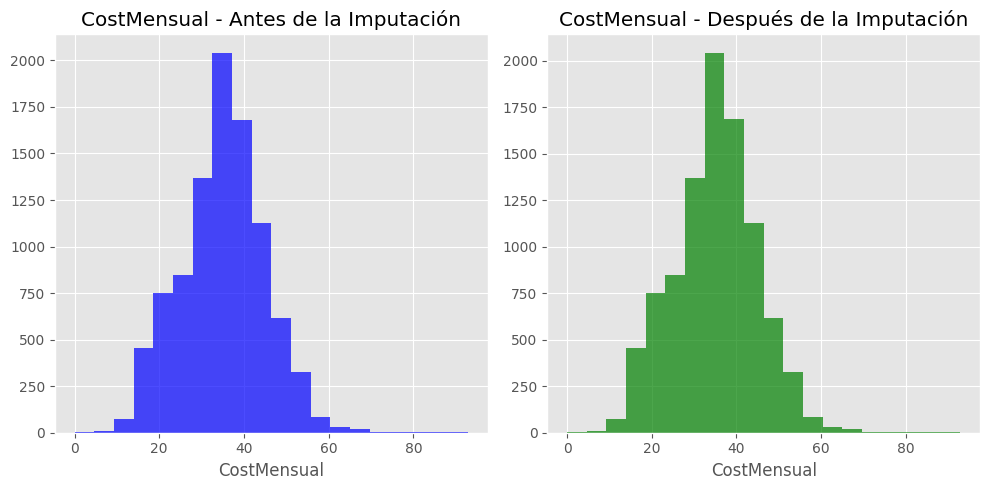

In [ ]:
#  comparativas de distribucion antes y despues de imputar
for columna_objetivo in columnas_con_nulos:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Histograma de antes
    axs[0].hist(df_dumm[columna_objetivo].dropna(), bins=20, color='blue', alpha=0.7)
    axs[0].set_title(f'{columna_objetivo} - Antes de la Imputación')
    axs[0].set_xlabel(columna_objetivo)

    # Histograma de despues
    axs[1].hist(data_imputado[columna_objetivo], bins=20, color='green', alpha=0.7)
    axs[1].set_title(f'{columna_objetivo} - Después de la Imputación')
    axs[1].set_xlabel(columna_objetivo)

    plt.tight_layout()
    plt.show()

## Outliers y balanceo de clases

In [ ]:
#CARGAR
#data_imputado_ruta = '/content/drive/MyDrive/TFG/DATASHEETS/data_imputado.xlsx'

#data_imputado = pd.read_excel(data_imputado_ruta)

In [ ]:
df=data_imputado.copy()

In [ ]:
# Porcentaje de valores 1 y 0 en la variable BaixaDefinitiva
porcentaje_valores = df['BaixaDefinitiva'].value_counts(normalize=True) * 100

print("Porcentaje de valores en BaixaDefinitiva:")
print(porcentaje_valores)

Porcentaje de valores en BaixaDefinitiva:
1    74.735618
0    25.264382
Name: BaixaDefinitiva, dtype: float64


In [ ]:
columnas_numericas = df.select_dtypes(include=['int64', 'float64','uint8']).columns
datos_numericos = df[columnas_numericas].to_numpy()

In [ ]:
# OUTLIERS MinCovDet

# Calcular la matriz de covarianza robusta usando el estimador MCD
robust_cov = MinCovDet().fit(datos_numericos)

# Calcular las distancias de Mahalanobis para cada observación
mahalanobis_distances = robust_cov.mahalanobis(datos_numericos)

# Definir un umbral para identificar outliers
umbral_outliers = 5.0

# Identificar las filas con distancias de Mahalanobis que superan el umbral
outliers_indices = np.where(mahalanobis_distances > umbral_outliers)[0]

# Obtener las filas que son outliers
outliers_MCD = df.iloc[outliers_indices]

/usr/local/lib/python3.10/dist-packages/sklearn/covariance/_robust_covariance.py:747: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


In [ ]:
print(outliers_MCD.shape)

(9456, 77)


In [ ]:
# OUTLIERS Isolation Forest
modelo_isolation_forest = IsolationForest(contamination=0.01)

# Ajustar el modelo y predecir outliers
df['is_outlier'] = modelo_isolation_forest.fit_predict(datos_numericos)

# Filtrar los registros identificados como outliers
outliers_IF = df[df['is_outlier'] == -1]

In [ ]:
print(outliers_IF.shape)

(95, 78)


In [ ]:
# Ignorar outliers
data_no_marcado = data_imputado.copy()

# Mantener outliers marcados
data_con_outliers = df.copy()

# Eliminar outliers
indices_outliers = outliers_IF[outliers_IF['is_outlier'] == -1].index
df = df.drop(indices_outliers)
df = df.drop('is_outlier', axis=1)

data_sin_outliers=df.copy()

# FASE 2 Entrenamiento delo modelo

In [ ]:
df=data_sin_outliers.copy()

In [ ]:
from sksurv.util import Surv
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM, FastSurvivalSVM, HingeLossSurvivalSVM,HingeLossSurvivalSVM
from sksurv.functions import StepFunction
from sksurv.ensemble import RandomSurvivalForest
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.model_selection import KFold
from sksurv.metrics import cumulative_dynamic_auc
from sksurv.metrics import integrated_brier_score
set_config(display="text")

## Seleccion del modelo

In [ ]:
model1 = CoxPHSurvivalAnalysis(alpha=0.5)
model2 = CoxnetSurvivalAnalysis(fit_baseline_model=True)
model3 = RandomSurvivalForest(n_estimators=100, max_depth=5)
model4 = FastKernelSurvivalSVM()
model5 = FastSurvivalSVM()
model6 = GradientBoostingSurvivalAnalysis()

modelos=[model1, model2, model3, model4, model5, model6]

# Seleccionar las variables predictoras que se desean incluir en el modelo
predictors = [col for col in df.columns if col not in ['BaixaDefinitiva', 'dias_totales','period_solic_baixa']]

# Definir las características (X) y las etiquetas (y)
X = df[predictors]
y = df[['BaixaDefinitiva', 'dias_totales']]

In [ ]:
# Entrenamiento rapido con conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Lo smétodos esperan un array compuesta por evento y tiempo como respuesta
y_train_np = Surv.from_dataframe('BaixaDefinitiva', 'dias_totales', y_train)
y_test_np = Surv.from_dataframe('BaixaDefinitiva', 'dias_totales', y_test)

for model in modelos:
    model.fit(X_train, y_train_np)

## Evaluacion del modelo

In [ ]:
for model in modelos:
    cindex = model.score(X_test, y_test_np)
    print(f"El c-index del algoritmo '{type(model).__name__}' es: {cindex}")

El c-index del algoritmo 'CoxPHSurvivalAnalysis' es: 0.8749683570692541
El c-index del algoritmo 'CoxnetSurvivalAnalysis' es: 0.8799080046935773
El c-index del algoritmo 'RandomSurvivalForest' es: 0.8719596727599783
El c-index del algoritmo 'FastKernelSurvivalSVM' es: 0.7605369098035011
El c-index del algoritmo 'FastSurvivalSVM' es: 0.9108577691212646
El c-index del algoritmo 'GradientBoostingSurvivalAnalysis' es: 0.9547241778794322


In [ ]:
# Dividir los datos en folds para Cross Validation
kf = KFold(n_splits=5, shuffle=True)

for model in modelos:
    cv_results = []
    for train_index, test_index in kf.split(df):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        y_train_np = Surv.from_dataframe('BaixaDefinitiva', 'dias_totales', y_train)
        y_test_np = Surv.from_dataframe('BaixaDefinitiva', 'dias_totales', y_test)

        # Entreno del modelo
        model.fit(X_train, y_train_np)

        # Evaluación del modelo
        cv_results.append(model.score(X_test, y_test_np))

    # error medio
    c_index_avg=np.mean(cv_results)
    print(f"El c-index del algoritmo '{type(model).__name__}' es: {c_index_avg}")

El c-index del algoritmo 'CoxPHSurvivalAnalysis' es: 0.8732212864061879
El c-index del algoritmo 'CoxnetSurvivalAnalysis' es: 0.8780073386432203
El c-index del algoritmo 'RandomSurvivalForest' es: 0.8708468734202196


<ipython-input-104-2688c270b299>:34: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train_np)
<ipython-input-104-2688c270b299>:34: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train_np)
<ipython-input-104-2688c270b299>:34: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train_np)
<ipython-input-104-2688c270b299>:34: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train_np)
<ipython-input-104-2688c270b299>:34: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train_np)


El c-index del algoritmo 'FastKernelSurvivalSVM' es: 0.7652486514609181


<ipython-input-104-2688c270b299>:34: ConvergenceWarning: Optimization did not converge: Warning: Maximum number of iterations has been exceeded.
  model.fit(X_train, y_train_np)


El c-index del algoritmo 'FastSurvivalSVM' es: 0.9078882027683648
El c-index del algoritmo 'GradientBoostingSurvivalAnalysis' es: 0.9518212095600511


In [ ]:

# Asume que tienes X_test, y_test y que los modelos ya están entrenados
# Calcula el Brier Score integrado para cada modelo
for model in [model1 , model2, model3,  model6]:
    pred_surv = model.predict_survival_function(X_test, return_array=True)
    # Ajustar el rango de tiempos para que esté dentro del rango de seguimiento de tus datos
    min_time = y_test_np['dias_totales'].min()
    max_time = y_test_np['dias_totales'].max()-1
    # Asegurándote de que el rango de tiempos esté dentro de los límites de tus datos
    times = np.linspace(min_time, max_time, num=pred_surv.shape[1])
    ibs = integrated_brier_score(y_test_np, y_test_np, pred_surv, times)
    print(f"Integrated Brier Score for {type(model).__name__}: {ibs}")


Integrated Brier Score for CoxPHSurvivalAnalysis: 0.16034807337139584
Integrated Brier Score for CoxnetSurvivalAnalysis: 0.14479654969393985
Integrated Brier Score for RandomSurvivalForest: 0.12252872121701221
Integrated Brier Score for GradientBoostingSurvivalAnalysis: 0.12548748825038772


In [ ]:
 '''ALMACENAJE DE LOS MODELOS
 import joblib
 from google.colab import drive

# Guardar el modelo
joblib.dump(model1, '/content/drive/MyDrive/model1.joblib')
joblib.dump(model2, '/content/drive/MyDrive/model2.joblib')
joblib.dump(model3, '/content/drive/MyDrive/model3.joblib')
joblib.dump(model4, '/content/drive/MyDrive/model4.joblib')
joblib.dump(model5, '/content/drive/MyDrive/model5.joblib')
joblib.dump(model6, '/content/drive/MyDrive/model6.joblib')'''

## Resultados

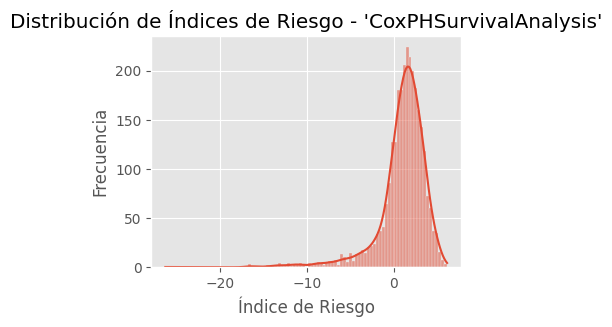

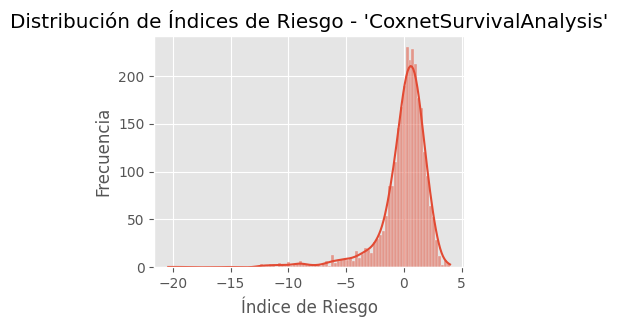

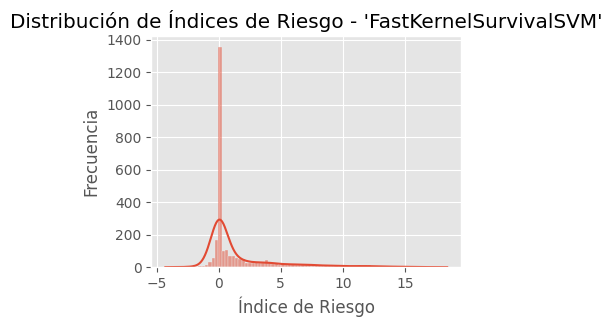

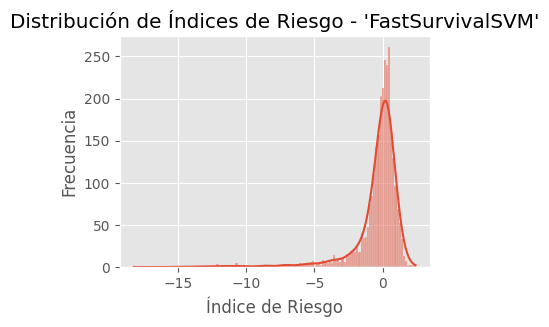

In [ ]:
modelos=[model1, model2, model4, model5]

for model in modelos:
    plt.figure(figsize=(4, 3))
    risk_scores = model.predict(X_test)
    sns.histplot(risk_scores, kde=True)
    plt.title(f"Distribución de Índices de Riesgo - '{type(model).__name__}'")
    plt.xlabel("Índice de Riesgo")
    plt.ylabel("Frecuencia")
    plt.show()


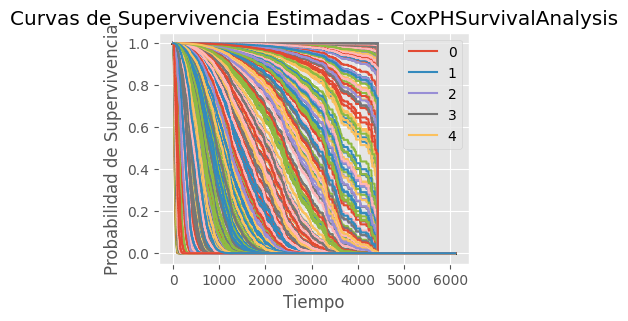

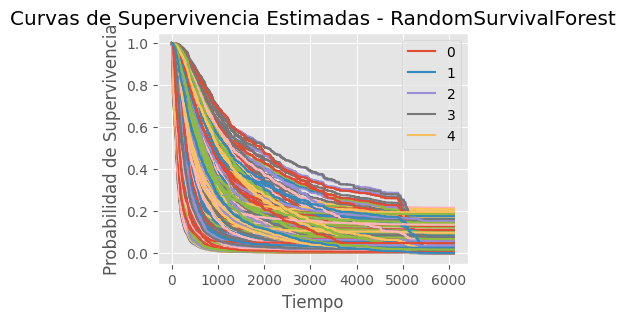

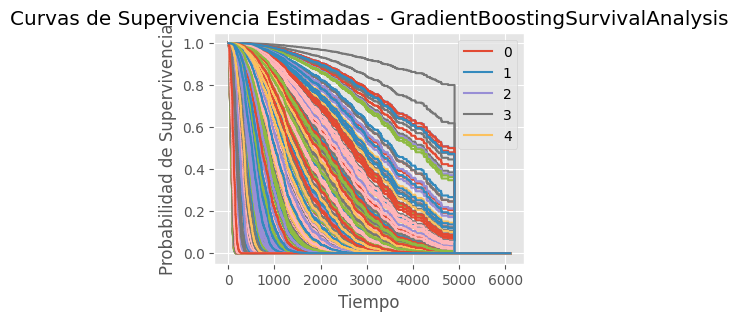

In [ ]:
modelos=[model1, model3, model6]

for model in modelos:
    plt.figure(figsize=(4, 3))
    surv_funcs_rf = model.predict_survival_function(X_test)
    for i, surv_func in enumerate(surv_funcs_rf):
        plt.step(surv_func.x, surv_func.y, where="post", label=str(i) if i < 5 else None)

    plt.title(f"Curvas de Supervivencia Estimadas - {type(model).__name__}")
    plt.xlabel("Tiempo")
    plt.ylabel("Probabilidad de Supervivencia")
    plt.legend()
    plt.show()

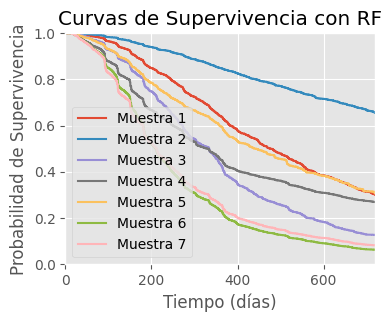

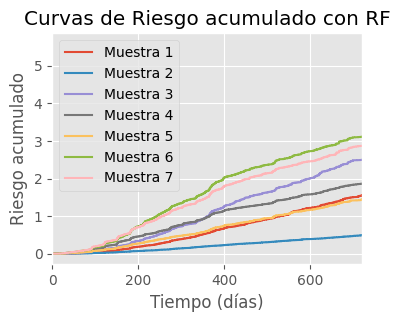

In [ ]:
models = [model3]

for model in models:
  plt.figure(figsize=(4, 3))
  # Obtener las curvas de supervivencia
  survival_functions = model3.predict_survival_function(X_test)
  hazard_functions = model3.predict_cumulative_hazard_function(X_test)

  # Graficar las curvas de supervivencia
  for i in range(7):
    time_points = survival_functions[i].x
    survival_probs = survival_functions[i](time_points)
    plt.step(time_points, survival_probs, label=f'Muestra {i + 1}')

  plt.legend()
  plt.title('Curvas de Supervivencia con RF')
  plt.xlabel('Tiempo (días)')
  plt.ylabel('Probabilidad de Supervivencia')
  plt.xlim(0, 720)
  plt.ylim(0, 1)

  plt.show()

  plt.figure(figsize=(4, 3))
  # Obtener las curvas de riesgo
  hazard_functions = model3.predict_cumulative_hazard_function(X_test)

  # Graficar las curvas de riesgo
  for i in range(7):
    time_points = hazard_functions[i].x
    hazard_probs = hazard_functions[i](time_points)
    plt.step(time_points, hazard_probs, label=f'Muestra {i + 1}')

  plt.legend()
  plt.title('Curvas de Riesgo acumulado con RF')
  plt.xlabel('Tiempo (días)')
  plt.ylabel('Riesgo acumulado')
  plt.xlim(0, 720)

  plt.show()

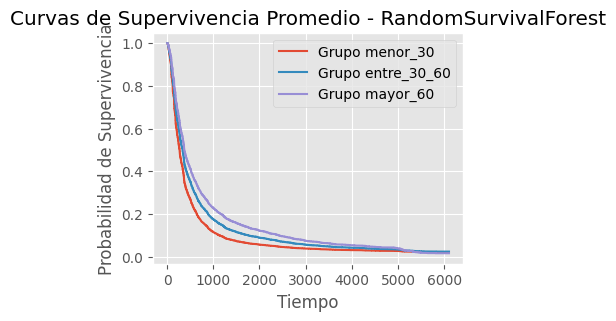

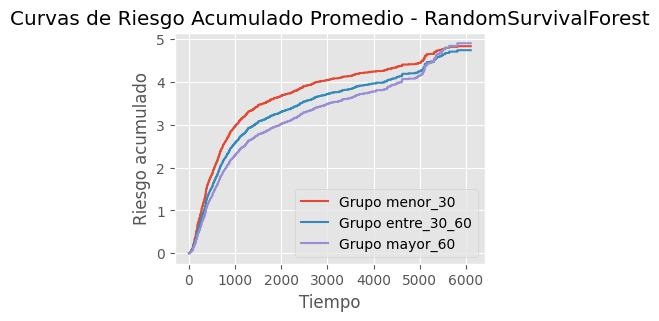

In [ ]:
# CURVAS DE SUPERVIVENCIA Y RIESGO POR UNA VARIABLE
grupos_edad = {
    'menor_30': X_test['Edat_Alta'] < 30,
    'entre_30_60': (X_test['Edat_Alta'] >= 30) & (X_test['Edat_Alta'] <= 60),
    'mayor_60': X_test['Edat_Alta'] > 60
}

models = [model3]

for model in models:
    plt.figure(figsize=(4, 3))

    for grupo_nombre, grupo_mascara in grupos_edad.items():
        X_grupo = X_test[grupo_mascara]
        y_grupo = y_test[grupo_mascara]

        # Verificar si el grupo está vacío
        if len(X_grupo) == 0:
            continue

        # Obtener las funciones de supervivencia
        surv_funcs = model.predict_survival_function(X_grupo)

        # Calcular la función de supervivencia promedio para el grupo
        curva_promedio = np.mean([func.y for func in surv_funcs], axis=0)

        # Graficar la curva promedio
        plt.step(surv_funcs[0].x, curva_promedio, where="post", label=f'Grupo {grupo_nombre}')

    plt.title(f"Curvas de Supervivencia Promedio - {type(model).__name__}")
    plt.xlabel("Tiempo")
    plt.ylabel("Probabilidad de Supervivencia")
    plt.legend()
    plt.show()

    plt.figure(figsize=(4, 3))
    for grupo_nombre, grupo_mascara in grupos_edad.items():
        X_grupo = X_test[grupo_mascara]
        y_grupo = y_test[grupo_mascara]

        # Verificar si el grupo está vacío
        if len(X_grupo) == 0:
            continue

        # Obtener las funciones de supervivencia
        hzd_funcs = model.predict_cumulative_hazard_function(X_grupo)

        # Calcular la función de supervivencia promedio para el grupo
        curva_promedio = np.mean([func.y for func in hzd_funcs], axis=0)

        # Graficar la curva promedio
        plt.step(hzd_funcs[0].x, curva_promedio, where="post", label=f'Grupo {grupo_nombre}')

    plt.title(f"Curvas de Riesgo Acumulado Promedio - {type(model).__name__}")
    plt.xlabel("Tiempo")
    plt.ylabel("Riesgo acumulado")
    plt.legend()
    plt.show()


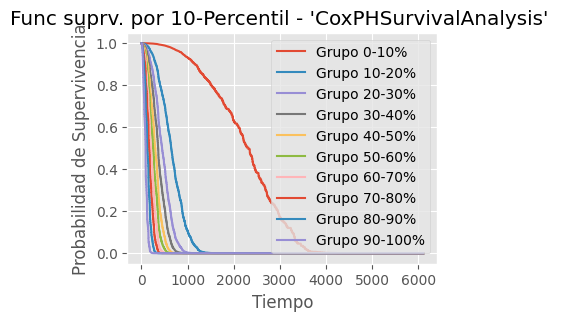

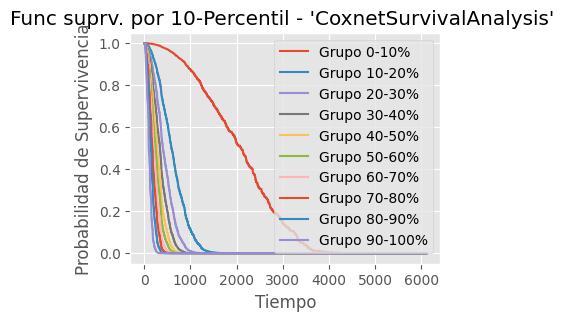

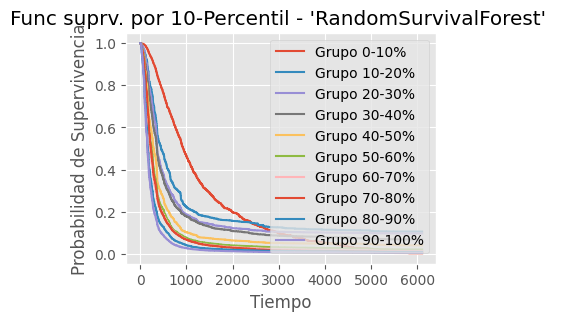

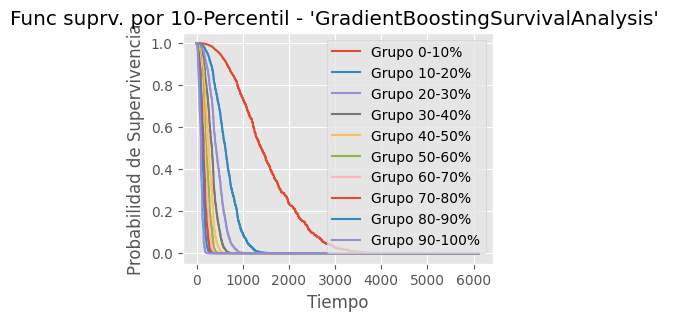

In [ ]:
# AGRUPADAS POR PERCENTILES

models_funcion_surv=[model1, model2, model3, model6]

for model in models_funcion_surv:
    predicciones = model.predict(X_test)
    df_predicciones = pd.DataFrame(predicciones, columns=['probabilidad_supervivencia'])

    percentiles = np.percentile(df_predicciones['probabilidad_supervivencia'], np.linspace(0, 100, 11))
    etiquetas_percentiles = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']

    df_predicciones['grupo_percentil'] = pd.cut(df_predicciones['probabilidad_supervivencia'], percentiles, include_lowest=True, labels=etiquetas_percentiles)

    # Utilizar predict_survival_function para obtener las funciones de supervivencia
    surv_funcs = model.predict_survival_function(X_test)

    representantes = df_predicciones.groupby('grupo_percentil')['probabilidad_supervivencia'].median()
    # índice de la observación más cercana a la mediana en cada grupo
    indices_representativos = df_predicciones.groupby('grupo_percentil').apply(lambda x: (x['probabilidad_supervivencia'] - representantes[x.name]).abs().idxmin())
    plt.figure(figsize=(4, 3))

    # Graficar la función de supervivencia de cada representante
    for indice in indices_representativos:

        surv_func = surv_funcs[indice]
        plt.step(surv_func.x, surv_func.y, where="post", label=f'Grupo {df_predicciones.loc[indice, "grupo_percentil"]}')

    plt.title(f"Func suprv. por 10-Percentil - '{type(model).__name__}' ")
    plt.xlabel("Tiempo")
    plt.ylabel("Probabilidad de Supervivencia")
    plt.legend()
    plt.show()

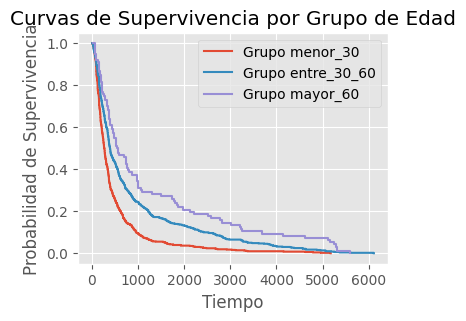

In [ ]:
# Utilizando Kaplan Meier

# Crear categorías de edad
categorias_edad = {
    'menor_30': X_test['Edat_Alta'] < 30,
    'entre_30_60': (X_test['Edat_Alta'] >= 30) & (X_test['Edat_Alta'] <= 60),
    'mayor_60': X_test['Edat_Alta'] > 60
}

# Calcular y graficar las curvas de supervivencia para cada categoría
plt.figure(figsize=(4, 3))

for nombre, mascara in categorias_edad.items():
    # Filtrar datos por grupo de edad
    X_grupo = X_test[mascara]
    y_grupo = y_test[mascara]

    # Calcular predicciones de riesgo para el grupo
    riesgo_predicho = model4.predict(X_grupo)

    # Calcular las curvas de supervivencia utilizando Kaplan-Meier
    tiempo, prob_surv = kaplan_meier_estimator(y_grupo['BaixaDefinitiva'].astype('bool'), y_grupo['dias_totales'])

    # Graficar la curva de supervivencia
    plt.step(tiempo, prob_surv, where="post", label=f'Grupo {nombre}')

# Configuración del gráfico
plt.title("Curvas de Supervivencia por Grupo de Edad")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad de Supervivencia")
plt.legend()
plt.show()


In [ ]:
survival_functions = model6.predict_survival_function(X_test)
cum_hazard_functions = model6.predict_cumulative_hazard_function(X_test)

# Encuentra el índice donde el tiempo es igual o más cercano a 61
indice_tiempo = np.where(survival_functions[0].x >= 61)[0][0]

# valores de supervivencia y riesgo en el día 61
survival_initials = [fn.y[indice_tiempo] for fn in survival_functions]
hazard_initials = [fn.y[indice_tiempo] for fn in cum_hazard_functions]

survival_initials_pd = pd.DataFrame({"survival_initial": survival_initials})
hazard_initials_pd = pd.DataFrame({"hazard_initial": hazard_initials})

X_test_with_initials = pd.concat([X_test, survival_initials_pd, hazard_initials_pd], axis=1)

# Ordenado por supervivencia y riesgo
X_test_ord_by_surv = X_test_with_initials.sort_values(by="survival_initial", ascending=True)
X_test_ord_by_hazd = X_test_with_initials.sort_values(by="hazard_initial", ascending=False)

print(X_test_ord_by_surv[['survival_initial','hazard_initial']].head(10))
print(X_test_ord_by_hazd[['survival_initial','hazard_initial']].head(10))

      survival_initial  hazard_initial
1530          0.468932        0.017898
180           0.468932        0.017898
1555          0.468932        0.017898
951           0.468932        0.017898
516           0.482235        0.017898
880           0.482235        0.017898
154           0.483381        0.017898
2637          0.484103        0.017898
1110          0.485187        0.017898
1428          0.485187        0.017898
      survival_initial  hazard_initial
2682          0.997119        0.017898
1820          0.852536        0.017898
1812          0.999952        0.017898
1813          0.889741        0.017898
1814          0.926160        0.017898
1815          0.899276        0.017898
1816          0.714705        0.017898
1817          0.997092        0.017898
1818          0.935129        0.017898
1819          0.527248        0.017898


## Análisis de características

In [ ]:
coeficientes = model1.coef_.ravel()

# Calcular riesgo relativo
riesgo_relativo = np.exp(coeficientes)

# Crear DataFrame
df_coef = pd.DataFrame({
        'Factor de riesgo': X_test.columns,
        'Coefficiente [β]': coeficientes,
        'Riesgo relativo [exp(β)]': riesgo_relativo
    })

# Ordenar el DataFrame por 'Riesgo relativo [exp(β)]' de mayor a menor
df_coef = df_coef.sort_values(by='Riesgo relativo [exp(β)]', ascending=False)

print(df_coef.head(10))
print(df_coef.tail(10))

                   Factor de riesgo  Coefficiente [β]  \
17                  ratio_primer_us          4.173390   
16                   ratio_inactivo          3.403440   
27                       existe_app          0.837206   
56  act_preferida_PERSONAL_SERVICES          0.632005   
24                     freq_180dias          0.625020   
10                        Nutrition          0.605498   
59       act_preferida_TONING_CLASS          0.522020   
60      act_preferida_VIRTUAL_CLASS          0.403055   
52        act_preferida_CICLO_CLASS          0.358954   
54   act_preferida_FITNESS_TRAINING          0.272773   

    Riesgo relativo [exp(β)]  
17                 64.935230  
16                 30.067355  
27                  2.309903  
56                  1.881378  
24                  1.868284  
10                  1.832164  
59                  1.685428  
60                  1.496389  
52                  1.431831  
54                  1.313602  
                 Factor de ries

In [ ]:
indices=pd.Series(model5.coef_, index=X_test.columns)
indices_ordenados = indices.sort_values(ascending=False)

# Imprimir la Serie ordenada
print(indices_ordenados.head(10))
print(indices_ordenados.tail(10))

freq_30dias              0.058606
Nacionalitat_1           0.046461
franja_habitual_tarda    0.043585
dia_habitual_Tuesday     0.038775
Attended                 0.031124
dia_habitual_Monday      0.023342
percent_consumit         0.019111
GroupExercise            0.018234
Mes_de_Alta_9            0.016440
Mes_de_Alta_5            0.010736
dtype: float64
act_preferida_sin_reservas   -0.026987
Nacionalitat_2               -0.046080
existe_app                   -0.048334
ServiciosExtra_0.0           -0.053888
freq_180dias                 -0.065137
dia_habitual_No_acceso       -0.072560
franja_habitual_No_acceso    -0.072560
ratio_primer_us              -0.080026
freq_activa                  -0.151192
ratio_inactivo               -0.167396
dtype: float64


In [ ]:
importances = model6.feature_importances_

# Emparejar cada importancia con el nombre de su característica correspondiente
feature_names = X_test.columns
feature_importances = pd.DataFrame({'Característica': feature_names, 'Importancia': importances})

# Ordenar el DataFrame de mayor a menor importancia
feature_importances = feature_importances.sort_values(by='Importancia', ascending=False)

# Mostrar el DataFrame
print(feature_importances.head(10))


         Característica  Importancia
1        numero_accesos     0.426134
15       dias_sin_venir     0.199817
21          freq_activa     0.145436
16       ratio_inactivo     0.079271
17      ratio_primer_us     0.044206
14     percent_consumit     0.028938
24         freq_180dias     0.024016
13  period_primer_acces     0.022706
12    DiasModalitatPago     0.011478
11            Descuento     0.009977


In [ ]:
# para RF hereda permutation importance, porque no tiene feature. importance
''' ES MUY LENTO''
from sklearn.inspection import permutation_importance

X_test_array = X_test.values
result = pd.DataFrame()

result = permutation_importance(model3, X_test, y_test_np, n_repeats=5, random_state=0)'''

In [ ]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
numero_accesos,0.275975,0.005363
dias_sin_venir,0.191860,0.007995
freq_activa,0.108167,0.001504
ratio_inactivo,0.057608,0.000368
ratio_primer_us,0.021633,0.002704
freq_180dias,0.008719,0.000201
percent_consumit,0.006939,0.000399
freq_90dias,0.002874,0.000174
period_primer_acces,0.002848,0.000138
DiasModalitatPago,0.001884,0.000317


# Bibliografia

https://medium.com/@martacasdelg/c%C3%B3mo-identificar-y-tratar-outliers-con-python-bf7dd530fc3

http://exponentis.es/ejemplo-de-uso-de-dbscan-en-python-para-deteccion-de-outliers

https://carlosfernandovg.github.io/supervivencia_y_series_FC2021-1/funciones-para-el-an%C3%A1lisis-de-supervivencia.html

https://es.linkedin.com/pulse/an%C3%A1lisis-exploratorio-de-datos-con-python-almudena-bonaplata

https://joserzapata.github.io/courses/python-ciencia-datos/visualizacion/

https://colab.research.google.com/github/alonsosilvaallende/Random-Survival-Forest-GBCSG2/blob/master/Cox_PH_and_RSF_colab.ipynb#scrollTo=D0xxNWzI-N3j

https://colab.research.google.com/github/sebp/survival-cnn-estimator/blob/master/tutorial_tf2.ipynb#scrollTo=dKl8PQotvERc

https://dehesa.unex.es/bitstream/10662/16726/1/TDUEX_2023_Sobreiro_PN.pdf

https://www.kaggle.com/discussions/questions-and-answers/353100

https://www.7puentes.com/blog/2019/07/17/como-predecir-que-usuarios-o-clientes-se-van-a-dar-de-baja-en-tu-empresa/

http://eio.usc.es/pub/mte/descargas/ProyectosFinMaster/Proyecto_1269.pdf

https://sonery.medium.com/machine-learning-r-prediccion-churn-rate-954a477c6e35

https://www.kaggle.com/code/darango94/churn-de-clientes-project-daniela/notebook

https://learn.microsoft.com/es-es/fabric/data-science/customer-churn

https://repositorio.uchile.cl/bitstream/handle/2250/186972/Desarrollo-de-un-modelo-de-prediccion-de-fuga-de-clientes-y-diseno-de-experimento-para-la.pdf?sequence=1

https://repository.libertadores.edu.co/bitstream/handle/11371/4722/Quevedo_Sang_2022.pdf?sequence=1

https://blogvisionarios.com/articulos-data/analizando-el-abandono-de-clientes-con-python/

https://github.com/zangell44/survival-analysis-lifeline-basics/blob/master/customer_churn.ipynb

https://rpubs.com/arojasmor17/abandono

https://juandelacalle.medium.com/an%C3%A1lisis-de-supervivencia-una-herramienta-oculta-pero-clave-para-el-marketing-e5920bcfdd8f

https://rstudio-pubs-static.s3.amazonaws.com/438542_64aa278b60684f69be38236a5b58711f.html

https://scielo.isciii.es/scielo.php?script=sci_arttext&pid=S0003-31702022000400003

https://oa.upm.es/76129/1/TFM_JAIME_MORILLO_LEAL.pdf

https://analisisydecision.es/el-analisis-de-supervivencia-para-segmentar-el-churn/

https://rstudio-pubs-static.s3.amazonaws.com/438542_64aa278b60684f69be38236a5b58711f.html

https://elmundodelosdatos.com/identificacion-valores-perdidos-python/#:~:text=Los%20valores%20perdidos%20(missing%20values,de%20datos%20en%20una%20observaci%C3%B3n.

NUEVOS:
https://todoia.es/guia-completa-de-visualizacion-de-datos-con-python/

https://colab.research.google.com/github/sebp/survival-cnn-estimator/blob/master/tutorial_tf2.ipynb

https://github.com/jaredleekatzman/DeepSurv

https://todoia.es/guia-completa-de-visualizacion-de-datos-con-python/

file:///Users/Andres/Downloads/ijerph-18-10465-v2.pdf

https://www.kaggle.com/code/alessandromarceddu/churn-survival-analysis

https://www.kaggle.com/code/bryanb/survival-analysis-with-cox-model-implementation

https://www.kaggle.com/code/konradb/ts-7-survival-analysis

https://github.com/liupei101/Tutorial-Machine-Learning-Based-Survival-Analysis/blob/master/Tutorial_Survival_RF.ipynb

